In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rcParams['lines.linewidth'] = 2.5
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [3]:
def subtract_region_counts(xp: XPS_experiment, xpRef: XPS_experiment, region: str, inplace=False):
    dif = xp.dfx[region].dropna().counts.sub(xpRef.dfx[region].dropna().counts )
    if inplace:
        xp.dfx[region].counts.update(dif)
        return xp
    else:
        xpNew = deepcopy(xp)
        xpNew.dfx[region].counts = dif
    return xpNew

def plot_xp_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp, r, ax=ax[j][k], lb=lb)
                ax[j][k].legend(loc='center left')
                ax[j][k].invert_xaxis()
                
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass
        ax[j][k].set_yticks([])
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
        ax[j][k].text(s=r.replace('_', ' '), x=(ax[j][k].get_xlim()[0]*0.999), y=(ax[j][k].get_ylim()[1]*0.9))
        
    plt.xlabel('\nEnergy [eV]', ha='center')
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
    return ax

# FBI and FBI - Ba fits

## Import data

In [4]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if '/proc' in f:
        files_new.append(f)
# files = files_new
files_new

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/18062020_Cu_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/19062020_Cu_FBI_100pulses_1e-4M.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200628_Cu_FBI_100pulses_1e-4M_BaClO42_1e-4M.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200702_Cu_FBI_200pulses_1e-4M.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200706_Cu_FBI_200pulses_1e-4M_BaClO42_1e-4M_200pulses.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200716_Cu_FBI_400pulses_1e-4M.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200814_Cu_FBI_ester_200pulses_1e-4M.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200814_Cu_FBI_ester_200pulses_1e-4M_BaClO42_45min.xy']

In [5]:
files = files_new[:-1]
ali_fbi = []
ali_ba = []
for f in files:
    print(f)
    if 'BaClO42' in f:
        ali_ba.append(read_processed_xp(f))
    else:
        ali_fbi.append(read_processed_xp(f))

/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/18062020_Cu_clean.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/19062020_Cu_FBI_100pulses_1e-4M.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200628_Cu_FBI_100pulses_1e-4M_BaClO42_1e-4M.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200702_Cu_FBI_200pulses_1e-4M.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200706_Cu_FBI_200pulses_1e-4M_BaClO42_1e-4M_200pulses.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200716_Cu_FBI_400pulses_1e-4M.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/ALI/proc/20200814_Cu_FBI_ester_200pulses_1e-4M.xy


In [6]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    files_new.append(f)
files_new

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/

In [7]:
files = files_new[:-7]
# files.pop(4)
files.pop(6)

subl_exps = []
for f in files:
    print(f)
    subl_exps.append(read_processed_xp(f))

/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_subl_15min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_subl_60min.uxy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_9-Cu_FBI_subl_2p5min.uxy


In [42]:
matrix([[6.51323846e-01, 1.16140270e-03],
        [1.08637052e+00, 3.27288126e-03],
        [1.41274162e+00, 3.49811320e-03],
        [1.82644117e+00, 3.82795998e-03],
        [7.24651170e-01, 1.30998972e-03],
        [1.54539729e+00, 3.59823743e-03],
        [3.02141495e+00, 5.11686513e-03],
        [4.75515898e-01, 8.51986016e-04]])

matrix([[6.51323846e-01, 1.16140270e-03],
        [1.08637052e+00, 3.27288126e-03],
        [1.41274162e+00, 3.49811320e-03],
        [1.82644117e+00, 3.82795998e-03],
        [4.75515900e-01, 8.51990000e-04]])

### Spectra pre-treatment

In [8]:
fig, ax = plt.subplots(1, 4, sharex=True , figsize=(18, 6))
for j, xp in enumerate(ali_fbi[:4]):
    plot_region(xp, 'Cu_2p', ax=ax[j], col='r')
    trim_spectra(xp, subl_exps[0], 'Cu_2p', inplace=True)
    plot_region(xp, 'Cu_2p', ax=ax[j], )
cosmetics_plot()

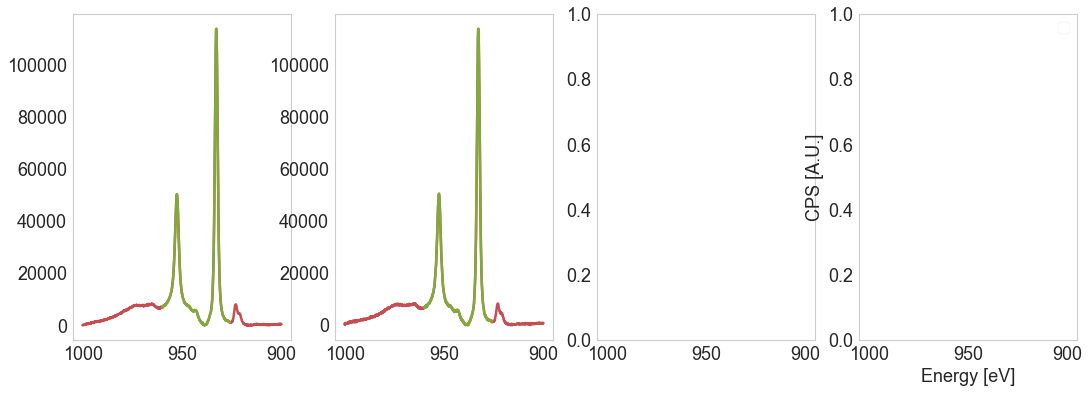

In [9]:
fig, ax = plt.subplots(1, 4, sharex=True , figsize=(18, 6))
for j, xp in enumerate(ali_ba[:4]):
    plot_region(xp, 'Cu_2p', ax=ax[j], col='r')
    trim_spectra(xp, subl_exps[0], 'Cu_2p', inplace=True)
    plot_region(xp, 'Cu_2p', ax=ax[j], )
cosmetics_plot()

In [10]:
region = 'Cu_2p'
df, dfRef = ali_fbi[0].dfx[region].dropna(), subl_exps[4].dfx[region].dropna()
scale_factor = (np.max(dfRef.counts) - np.min(dfRef.counts)) / (np.max(df.counts) - np.min(df.counts))
for xp in ali_fbi:
    scale_dfx(xp, scale_factor=scale_factor, inplace=True)
for xp in ali_ba:
    scale_dfx(xp, scale_factor=scale_factor, inplace=True)

subl_exps.pop(4);  # Remove clean cu exp

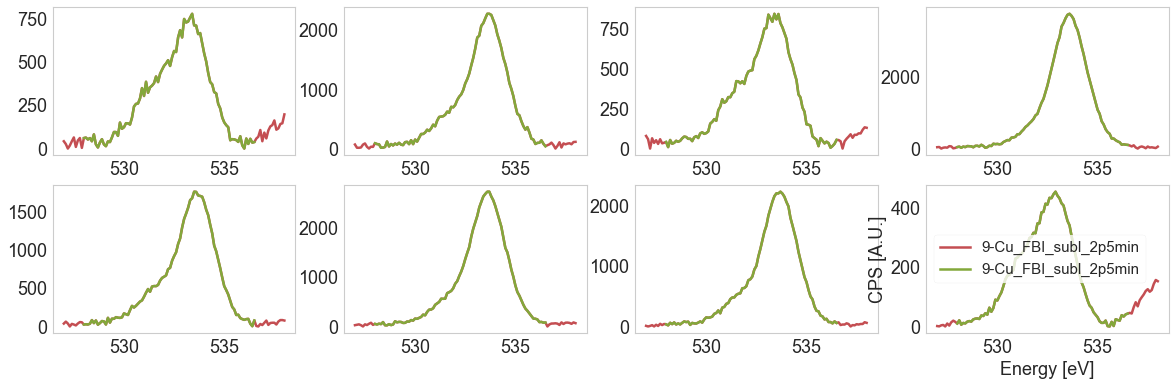

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(20, 6))
for j, xp in enumerate(subl_exps[:8]):
    i, k = j%2, j//2
    plot_region(xp, 'O_1s', ax=ax[i][k], col='r')
    trim_spectra(xp, ali_fbi[1], 'O_1s', inplace=True)
    plot_region(xp, 'O_1s', ax=ax[i][k], )

In [12]:
names = ['0.65 Layers', '1.1 Layers', '1.4 Layers', '1.8 Layers', '0.72 Layers', '1.5 Layers', '3.0 Layers', '0.47 Layers']
for i,xp in enumerate(subl_exps):
    xp.name = names[i]

In [13]:
for i,xp in enumerate(ali_fbi):
    xp.name = xp.name.replace('_', ' ').replace('FBI', 'ALI')

In [14]:
for i,xp in enumerate(ali_ba):
    print(xp.name)
    xp.name = xp.name.replace('_', ' ').replace('FBI', 'FBI-').replace('Ba', 'Ba(ClO$_4$)$_2$')

FBI_Ba_100_pulses
FBI_Ba_200_pulses


## Overview FBI regions

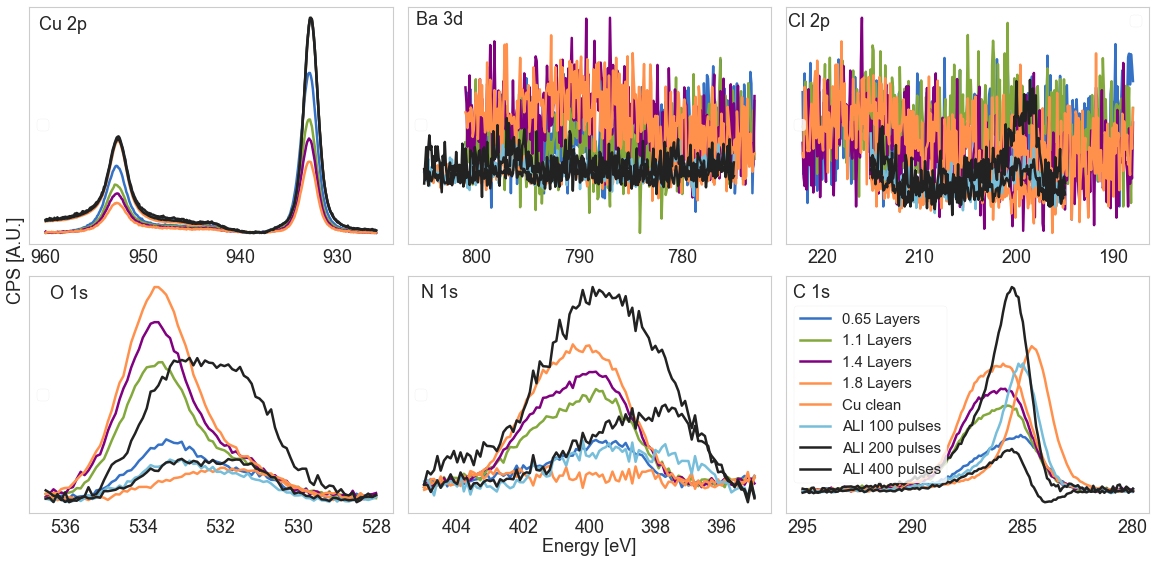

In [128]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions(subl_exps[:4] + ali_fbi[:4], regions, ncols=3);

In [120]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([subl_exps[0], subl_exps[7]] + [ali_fbi[1]], regions, ncols=3);

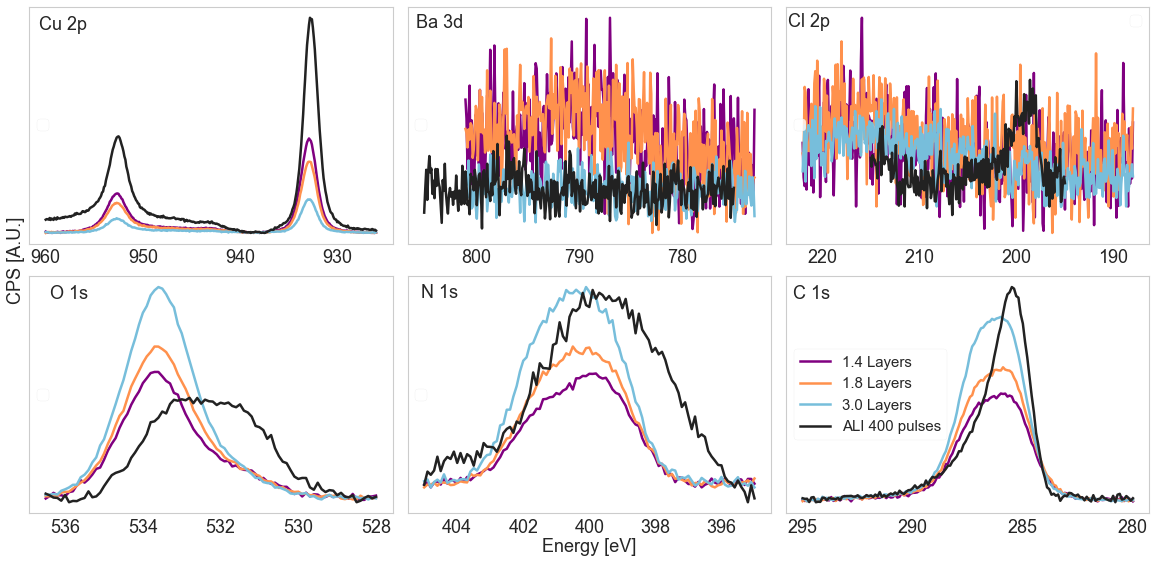

In [129]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([subl_exps[2], subl_exps[3], subl_exps[6]] + [ali_fbi[3]], regions, ncols=3);

### After "clean" substrate intensity subtraction

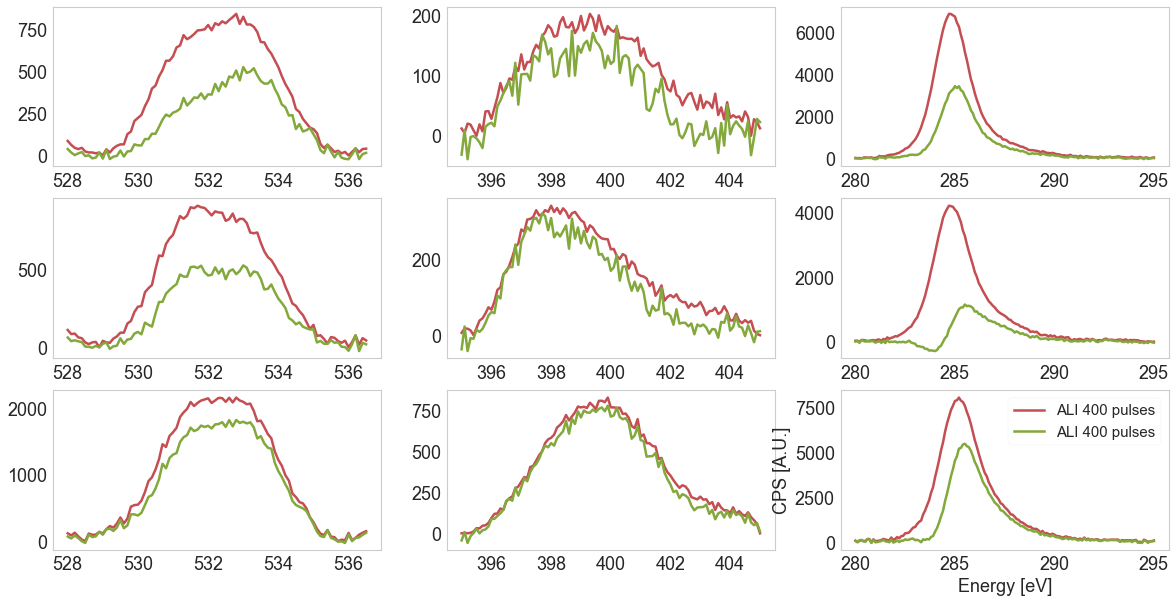

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
for j, xp in enumerate(ali_fbi[1:4]):
    for i,r in enumerate(['O_1s', 'N_1s', 'C_1s']):
        plot_region(xp, r, ax=ax[j][i], col='r')
        subtract_region_counts(xp, ali_fbi[0], r, inplace=True)
        plot_region(xp, r, ax=ax[j][i], )

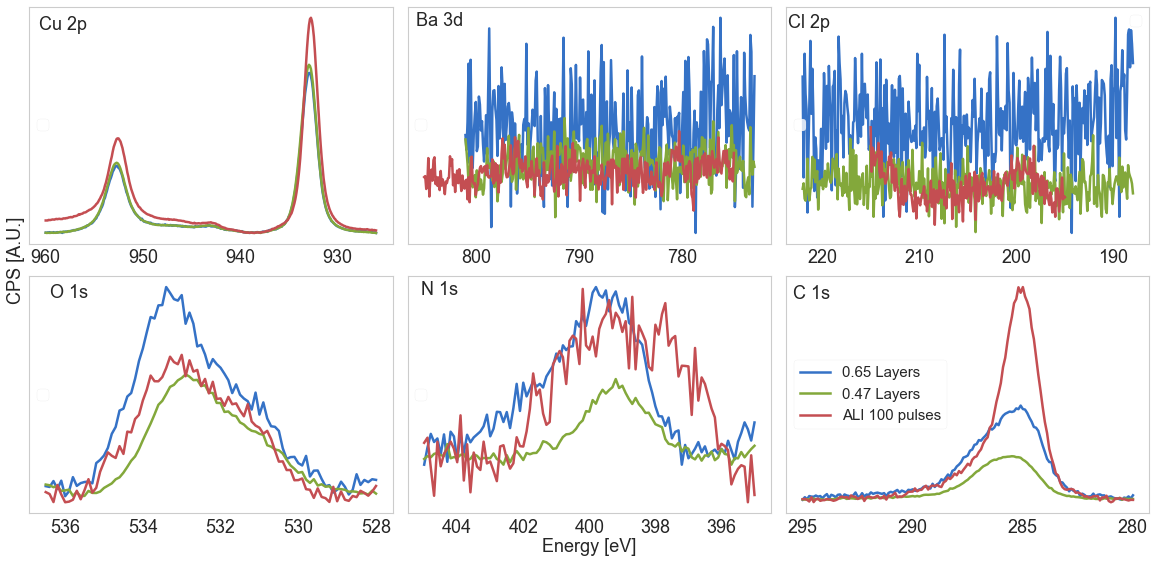

In [17]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([subl_exps[0], subl_exps[7]] + [ali_fbi[1]], regions, ncols=3);

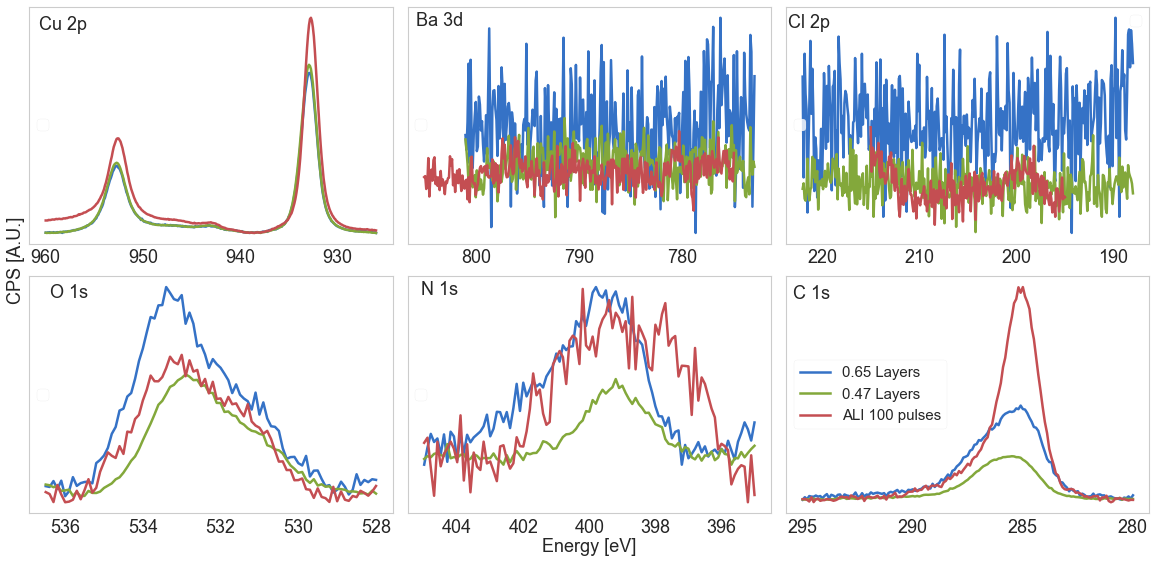

In [18]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([subl_exps[0], subl_exps[7]] + [ali_fbi[1]], regions, ncols=3);

In [27]:
subl_exps[2].color = 'purple'
subl_exps[3].color = 'y'
subl_exps[6].color = 'c'
ali_fbi[3].color = 'k'
ali_fbi[1].color = 'r'

In [125]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([subl_exps[2], subl_exps[3], subl_exps[6]] + [ali_fbi[3]], regions, ncols=3);

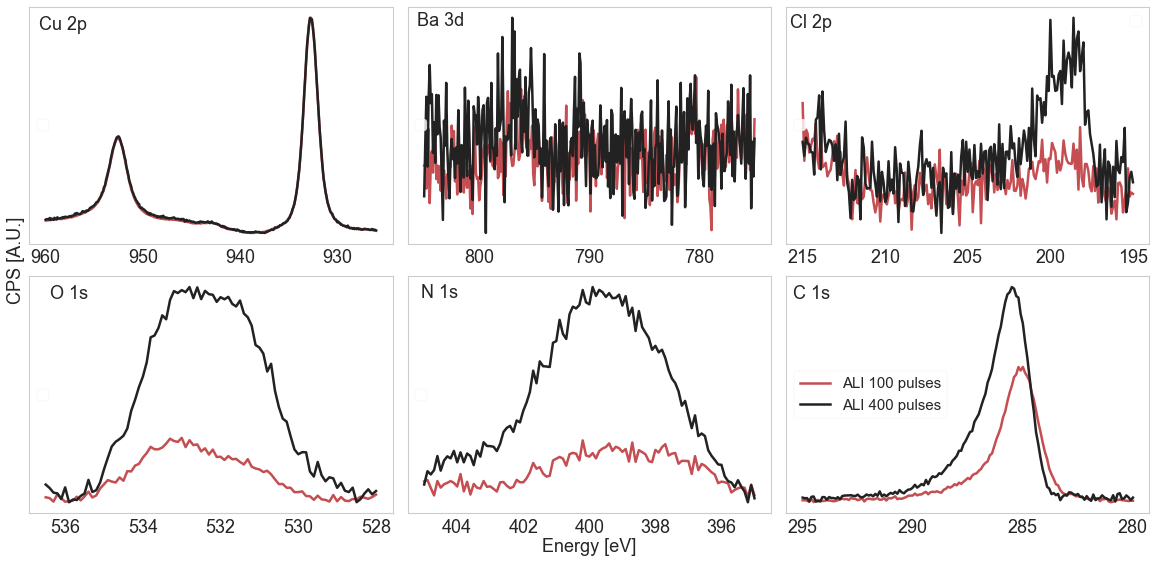

In [132]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([ali_fbi[1], ali_fbi[3]], regions, ncols=3);

## Overview regions FBI-Ba(ClO$_4$)$_2$

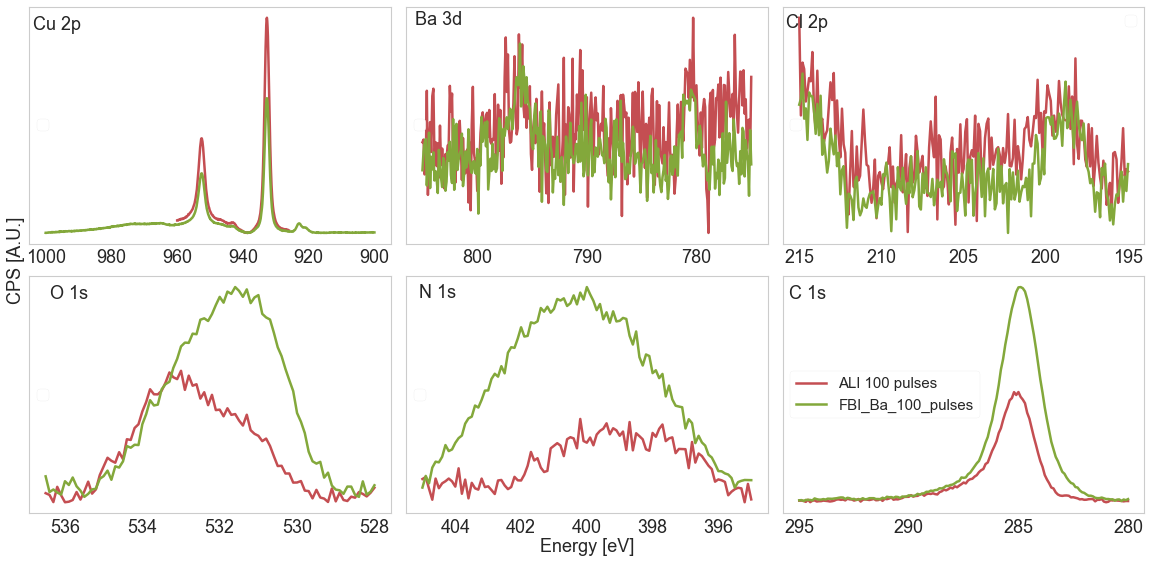

In [134]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([ali_fbi[1], ali_ba[0]], regions, ncols=3);

### Substract clean

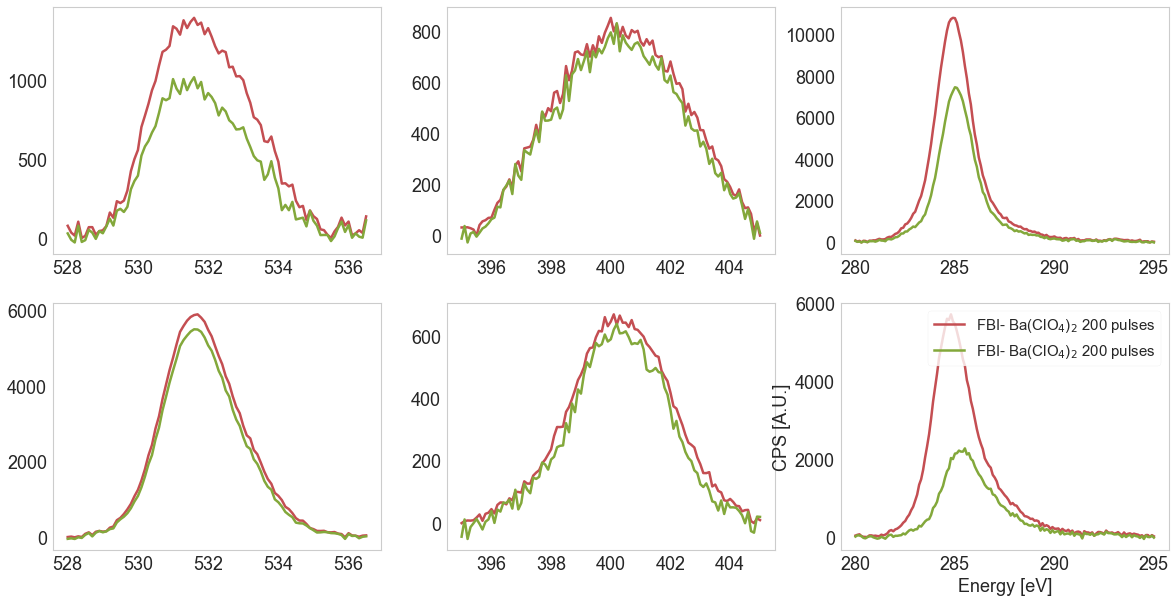

In [150]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for j, xp in enumerate(ali_ba):
    for i,r in enumerate(['O_1s', 'N_1s', 'C_1s']):
        plot_region(xp, r, ax=ax[j][i], col='r')
        xps = subtract_region_counts(xp, ali_fbi[0], r, inplace=True)
        plot_region(xps, r, ax=ax[j][i], )

In [167]:
ali_fbi[1].name = 'FBI 100 pulses'
ali_fbi[1].color = 'r'
ali_ba[0].color = 'c'

In [ ]:
rate = 2000 # Hz
area = 10 # mm2
10 radium atom / 1 micron2


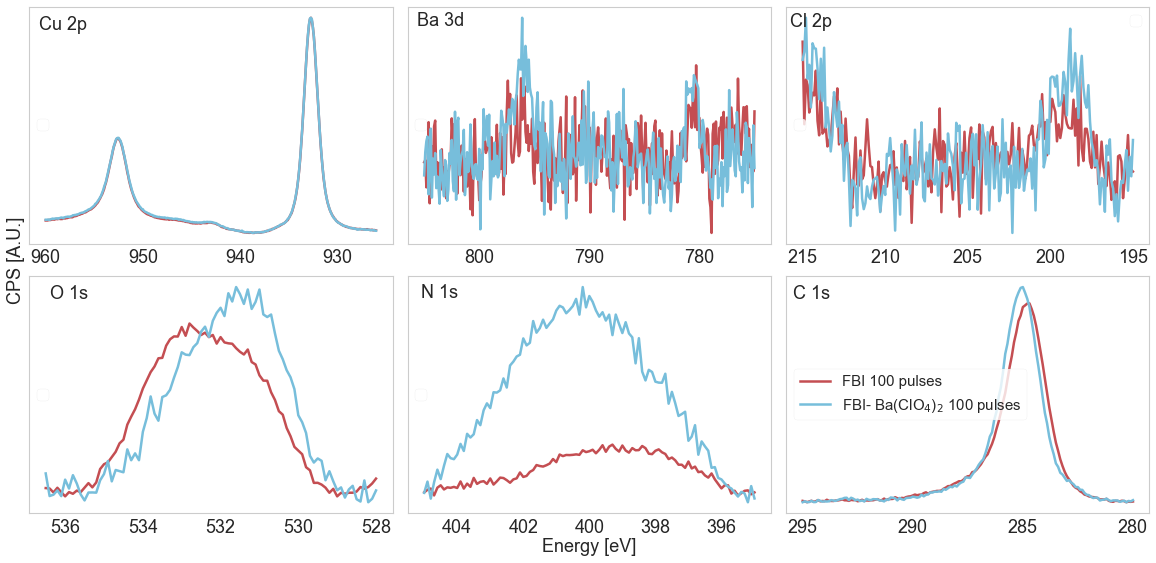

In [168]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([ali_fbi[1], ali_ba[0]], regions, ncols=3);

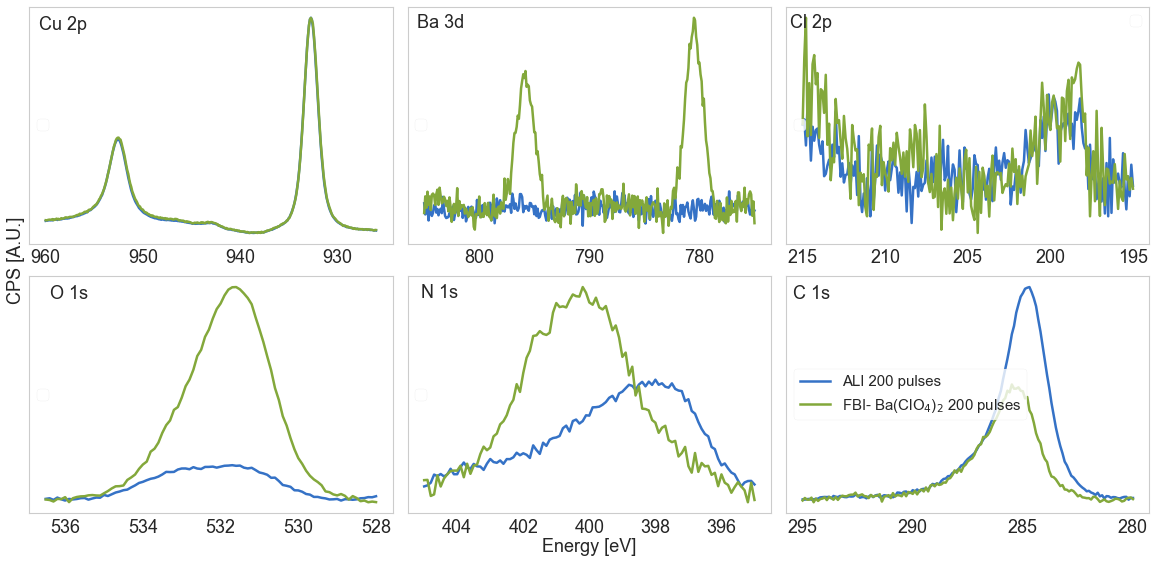

In [159]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([ali_fbi[2], ali_ba[1]], regions, ncols=3);

## Compare to FBI in MetOH

In [170]:
ali_metoh = read_processed_xp('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200916_Cu_FBI_metOH_400pulses.xy')
metoh_only = read_processed_xp('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200915_Cu_metOH_400pulses.xy')

In [171]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i,r in enumerate(['O_1s', 'N_1s', 'C_1s']):
    plot_region(ali_metoh, r, ax=ax[i], col='r')
    subtract_region_counts(ali_metoh, metoh_only, r, inplace=True)
    plot_region(ali_metoh, r, ax=ax[i])

In [181]:
region = 'Cu_2p'
df, dfRef = ali_metoh.dfx[region].dropna(), ali_fbi[1].dfx[region].dropna()
scale_factor = (np.max(dfRef.counts) - np.min(dfRef.counts)) / (np.max(df.counts) - np.min(df.counts))
scale_dfx(ali_metoh, scale_factor=scale_factor, inplace=True)

XPS_experiment(path='/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200916_Cu_FBI_metOH_400pulses.xy', delimiters="([42, 1275, 1614, 2057, 2186, 2619, 2848, 3267], [1205, 311, 151, 101, 171, 201, 301, 501], ['overview_', 'Ta_4d', 'C_1s', 'N_1s', 'O_1s', 'Cl_2p', 'Ba_3d', 'Cu_2p'])", name='FBI metOH', label='20200916_Cu_FBI_metOH_400pulses', date='2020.09.16', other_meta='Cu_FBI_metOH_400pulses', dfx=      Ba_3d               C_1s             Cl_2p             Cu_2p  \
     energy      counts energy     counts energy     counts energy   
0     805.0  390.325359  295.0   8.460285  215.0  64.510322  970.0   
1     804.9  429.727637  294.9  22.567632  214.9  79.920264  969.9   
2     804.8  266.531845  294.8  16.407024  214.8  20.848745  969.8   
3     804.7  293.393815  294.7  -0.797696  214.7  83.546133  969.7   
4     804.6  271.755228  294.6  -5.940365  214.6  84.301447  969.6   
...     ...         ...    ...        ...    ...        ...    ...   
1200    

In [188]:
ali_metoh.color = 'c'
ali_metoh.name = 'FBI metOH'
ali_fbi[1].name = 'FBI AcN'
subl_exps[7].color = 'g'

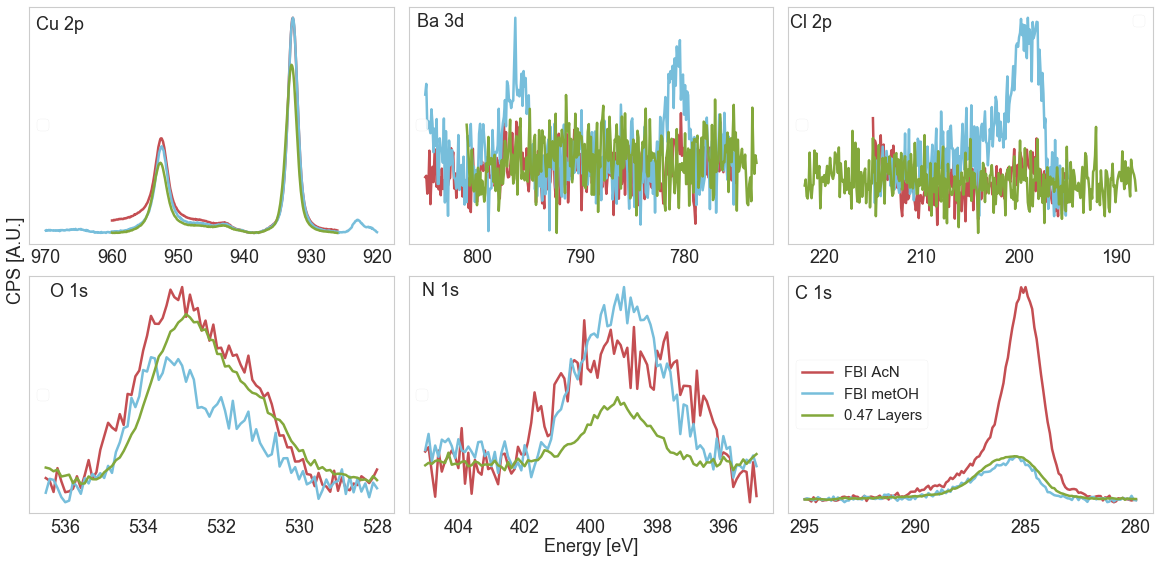

In [189]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions([ali_fbi[1], ali_metoh, subl_exps[7]], regions, ncols=3);

## Fit O

In [29]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
fitcu = fit_double_voigt(cu_exps[1], region, sepPt=532, plot_comps=True)
fitcu = fit_double_voigt(cu_exps[2], region, sepPt=532, plot_comps=True)
cosmetics_plot()

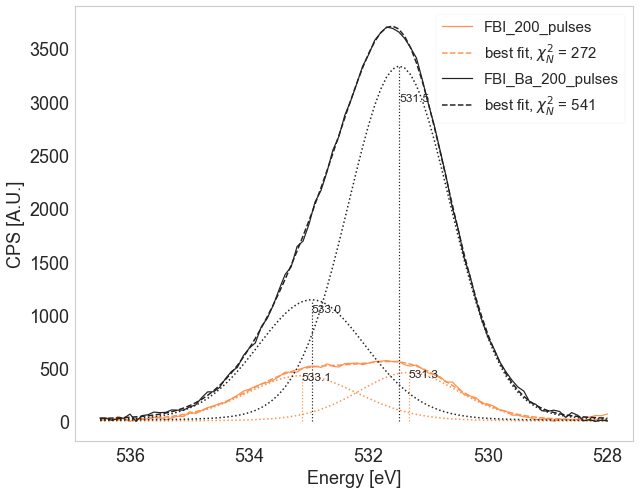

In [30]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
fitcu = fit_double_voigt(cu_exps[3], region, sepPt=532, plot_comps=True)
fitcu = fit_double_voigt(cu_exps[4], region, sepPt=532, plot_comps=True)
cosmetics_plot()

In [35]:
region = 'O_1s'
plt.figure(figsize=(12, 8))
fitcu = fit_double_voigt(cu_exps[6], region, sepPt=532, plot_comps=True)
fitcu = fit_double_voigt(cu_exps[7], region, sepPt=532, plot_comps=True)
cosmetics_plot()

In [6]:
shoulder = comps['v1_']
main = comps['v2_']
area_sho = np.trapz(shoulder, x=x[::-1])
area_main = np.trapz(main, x=x[::-1])
area_sho/(area_main*frac)

NameError: name 'frac' is not defined

### Compare to Sputter 1

In [10]:
region = 'O_1s'
plt.figure(figsize=(14,10))
fitcu = fit_double_voigt(normalise_dfx(cu_exps[1]), region, sepPt=532)

x = cu_exps[1].dfx[region].dropna().energy
comps = fitcu.eval_components(x=x)
ax = plt.gca()
# ax.plot(x, fitcu.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitcu.redchi)
for compo in comps:
    colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitcu.best_values[compo+'center']) )[0].get_color()

fitSput = fit_voigt(normalise_dfx(cu_exps[2]), region)
x = cu_exps[2].dfx[region].dropna().energy
cosmetics_plot()
# ax.plot(x, fitSput.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitSput.redchi)

In [ ]:
region = 'O_1s'

fitcu = fit_voigt(cu_exps[2], region)

x = cu_exps[1].dfx[region].dropna().energy
ax = plt.gca()
ax.plot(x, fitcu.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitcu.redchi)

### Compare to ALI deposition O

In [26]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_23_FBI_Au_crystal/20191023_FBI_Ba_1uM_40pulse_50ms_Au(788)_350mbar/proc/20191023_FBI_Ba_1uM_40pulse_50ms_Au(788)_350mbar.xy'

ali200mbar40p = read_processed_xp(path)
ali200mbar40p.name

'40pulses_200mbar'

In [33]:
fitcu = fit_double_voigt(ali200mbar40p, region, sepPt=532)

x = ali200mbar40p.dfx[region].dropna().energy
comps = fitcu.eval_components(x=x)
ax = plt.gca()
for compo in comps:
    colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitcu.best_values[compo+'center']) )[0].get_color()
ax.legend()

In [32]:
fitcu = fit_voigt(ali200mbar40p, region)

x = ali200mbar40p.dfx[region].dropna().energy

## Fit Ba 3d 

In [46]:
region = 'Ba_3d'
plt.figure(figsize=(10, 8))
plot_region(cu_exps[1], region)
plot_region(cu_exps[2], region)
cosmetics_plot()

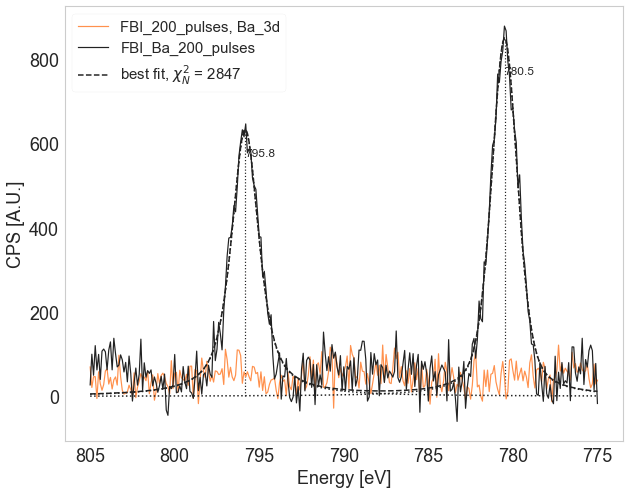

In [47]:
plt.figure(figsize=(10, 8))
plot_region(cu_exps[3], region)
fitcu = fit_double_voigt(cu_exps[4], region, sepPt=790, plot_comps=True)
cosmetics_plot()

In [45]:
plt.figure(figsize=(12, 8))
plot_region(cu_exps[6], region)
fitcu = fit_double_voigt(cu_exps[7], region, sepPt=790, plot_comps=True)
cosmetics_plot()

In [111]:
sigma1 = fitcu.params['v_sigma'].value
dsigma1 = fitcu.params['v_sigma'].stderr
sigma1, dsigma1
fitcu.params['v_center']
fitcu.params['v_sigma'].set(max=1.1*sigma1)

## Cl 2p, 2s

In [48]:
region = 'Cl_2p'
plt.figure(figsize=(10, 8))
plot_region(cu_exps[1], region)
plot_region(cu_exps[2], region)
cosmetics_plot()

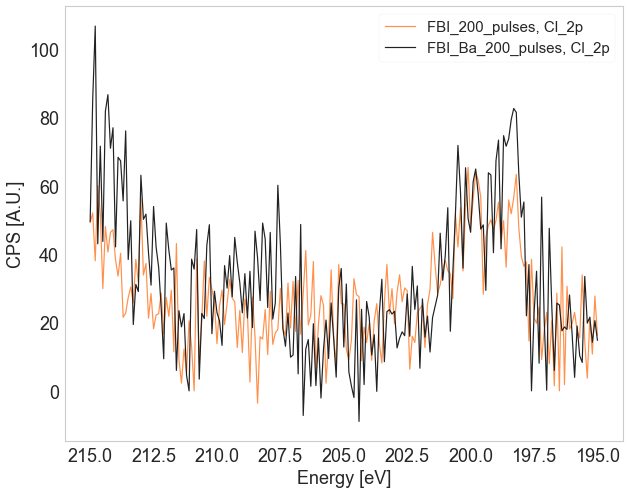

In [51]:
plt.figure(figsize=(10, 8))
plot_region(cu_exps[3], region)
plot_region(cu_exps[4], region)
# fitcu = fit_double_voigt(cu_exps[4], region, sepPt=199, plot_comps=True)
cosmetics_plot()

In [53]:
plt.figure(figsize=(10, 8))
plot_region(cu_exps[6], region)
plot_region(cu_exps[7], region)
# fitcu = fit_double_voigt(cu_exps[7], region, sepPt=199, plot_comps=True)
cosmetics_plot()

In [138]:
asf = {'Cl_2p' : 0.891}
asf['Cl_2s'] = 1.7 * 0.816 / 0.891
(area_2s/asf['Cl_2s']) * asf['Cl_2p'] / (area_main + area_sho)

1.7427445851854548

### Cl 2s

In [150]:
region = 'Cl_2s'

fitcu = fit_voigt(cu_exps[1], region)

x = cu_exps[1].dfx[region].dropna().energy
comps = fitcu.eval_components(x=x)
ax = plt.gca()
ax.plot(x, fitcu.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitcu.redchi)
for compo in comps:
    colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitcu.best_values[compo+'center']) )[0].get_color()
ax.legend()

main = comps['v_']

area_2s = np.trapz(main, x=x[::-1])
area_2s

375250.7679154272

#### X-ray satellite from C 1s?
It would have a displacement of 9.8 eV and a 6.4% intensity

(0.04635141521208889, 10.328630944435076)

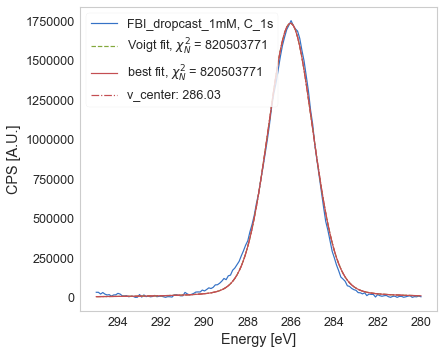

In [153]:
region = 'C_1s'

fitcu = fit_voigt(cu_exps[1], region)

x = cu_exps[1].dfx[region].dropna().energy
comps = fitcu.eval_components(x=x)
ax = plt.gca()
ax.plot(x, fitcu.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitcu.redchi)
for compo in comps:
    colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitcu.best_values[compo+'center']) )[0].get_color()
ax.legend()

main = comps['v_']

area_c = np.trapz(main, x=x[::-1])
area_2s/1.7*1 /area_c, fitcu.best_values['v_center'] - 275.7

##### Nope: diplacement of 10.3 eV and relative area 4.6%

##### Estimate Cl 2s ASF
from we get the factors of the Cl 2p, 2s orbitals relative to C (different scale)

Cl 2p 3/2: 1.59

Cl 2p 1/2: 0.816

Cl 2s: 1.7

#### Take whole Cl 2p

In [138]:
asf = {'Cl_2p' : 0.891}
asf['Cl_2s'] = 1.7 * 0.816 / 0.891
(area_2s/asf['Cl_2s']) * asf['Cl_2p'] / (area_main + area_sho)

1.7427445851854548

#### Compare to Cl 2p 1/2

In [141]:
asf = {'Cl_2p' : 0.816, 'Cl_2s' : 1.7}
area_2s/asf['Cl_2s'] / (area_main / asf['Cl_2p'])

17.99820597730019

#### Compare to Cl 2p 3/2

In [142]:
asf = {'Cl_2p' : 1.59, 'Cl_2s' : 1.7}
area_2s/asf['Cl_2s'] / (area_sho / asf['Cl_2p'])

3.0999245126998543

### After sputter

3.2563067526704677

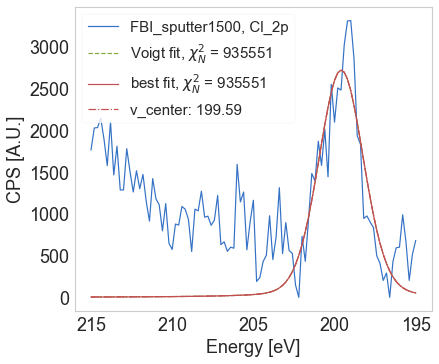

In [115]:
region = 'Cl_2p'

from lmfit.models import PseudoVoigtModel
mod = PseudoVoigtModel(prefix='v_')
pars = mod.make_params()
pars['v_sigma'].set(value=1)
pars['v_fraction'].set(value=0.2, min=0.15, max=0.2)
pars['v_center'].set(value=199.5, min=198, max=201)

fitcu = fit_voigt(cu_exps[2], region, pars=pars)

x = cu_exps[2].dfx[region].dropna().energy
comps = fitcu.eval_components(x=x)
ax = plt.gca()
ax.plot(x, fitcu.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitcu.redchi)
for compo in comps:
    colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitcu.best_values[compo+'center']) )[0].get_color()
ax.legend()

main = comps['v_']

area_main = np.trapz(main, x=x[::-1])

fitcu.params['v_fwhm'].value

28567.616935482165

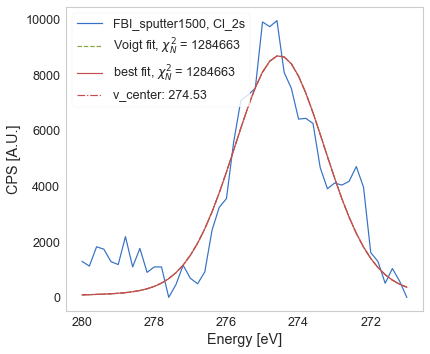

In [145]:
region = 'Cl_2s'

fitcu = fit_voigt(cu_exps[2], region)

x = cu_exps[2].dfx[region].dropna().energy
comps = fitcu.eval_components(x=x)
ax = plt.gca()
ax.plot(x, fitcu.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitcu.redchi)
for compo in comps:
    colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitcu.best_values[compo+'center']) )[0].get_color()
ax.legend()

main = comps['v_']

area_2s = np.trapz(main, x=x[::-1])
area_2s

#### Compare to Cl 2p 3/2

In [146]:
asf = {'Cl_2p' : 1.59, 'Cl_2s' : 1.7}
area_2s/asf['Cl_2s'] / (area_sho / asf['Cl_2p'])

0.23599540248690296

## N 1s

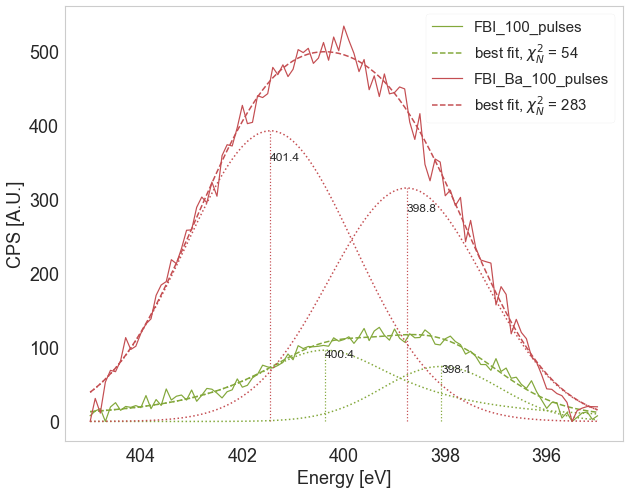

In [31]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
fitFBI = fit_double_voigt(cu_exps[1], region, sepPt=401, plot_comps=True)
fitFBIba = fit_double_voigt(cu_exps[2], region, sepPt=401, plot_comps=True)
cosmetics_plot()

In [32]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
fitFBI = fit_double_voigt(cu_exps[3], region, sepPt=401, plot_comps=True)
fitFBIba = fit_double_voigt(cu_exps[4], region, sepPt=401, plot_comps=True)
cosmetics_plot()

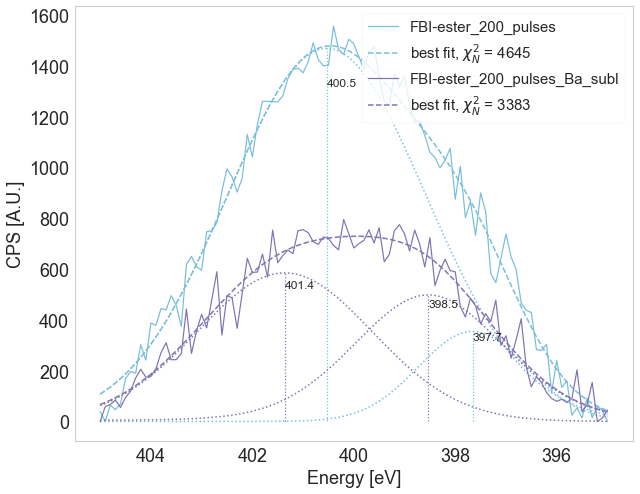

In [33]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
fitFBI = fit_double_voigt(cu_exps[-2], region, sepPt=401, plot_comps=True)
fitFBIba = fit_double_voigt(cu_exps[-1], region, sepPt=401, plot_comps=True)
cosmetics_plot()

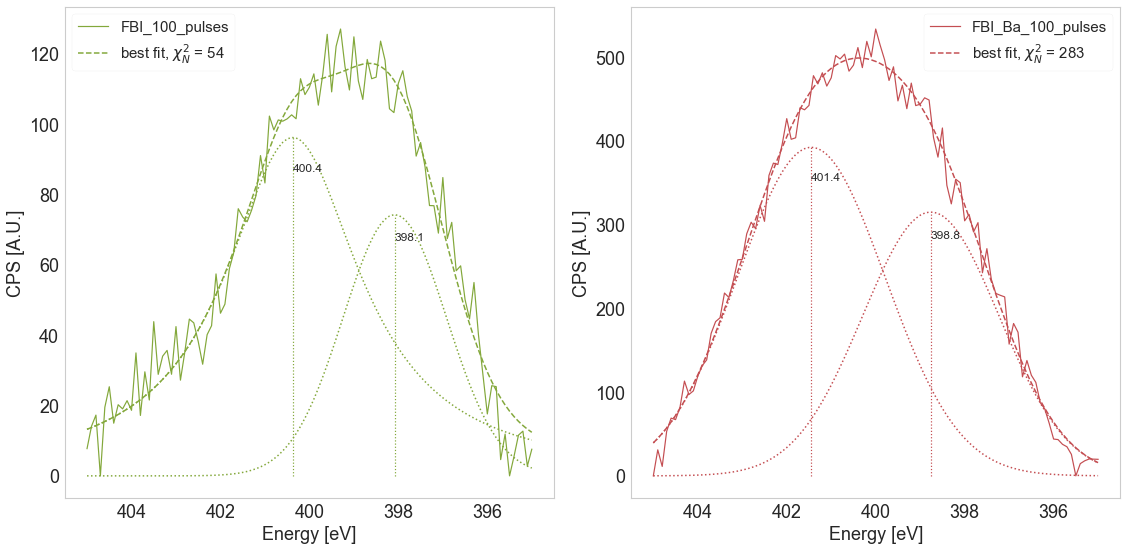

In [84]:
region = 'N_1s'
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fitN = []
for i, xp in enumerate(cu_exps[1:3]):
    fitFBI = fit_double_voigt(xp, region, sepPt=401, plot_comps=True, ax=ax[i])
    fitN.append(fitFBI)
plt.tight_layout()

In [85]:
region = 'N_1s'
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i, xp in enumerate(cu_exps[3:5]):
    fitFBI = fit_double_voigt(xp, region, sepPt=401, plot_comps=True, ax=ax[i])
    fitN.append(fitFBI)
plt.tight_layout()

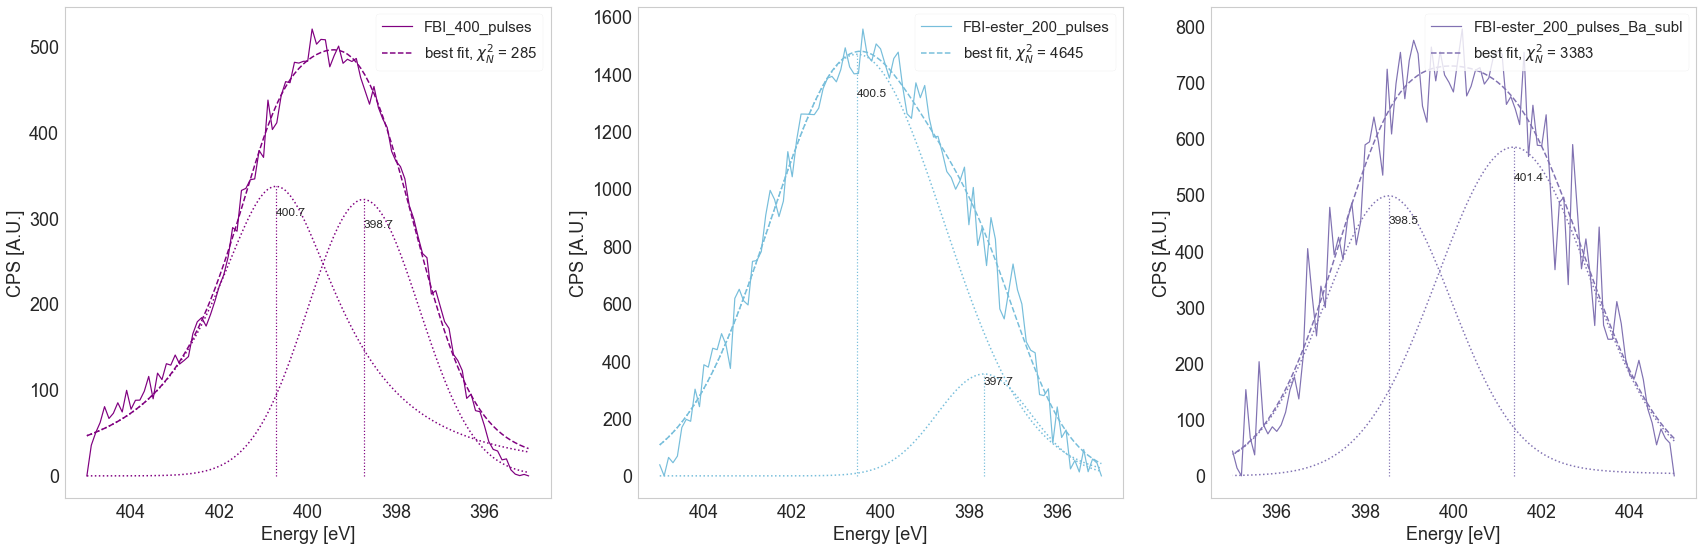

In [86]:
region = 'N_1s'
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
for i, xp in enumerate(cu_exps[5:]):
    fitFBI = fit_double_voigt(xp, region, sepPt=401, plot_comps=True, ax=ax[i])
    fitN.append(fitFBI)
plt.tight_layout()

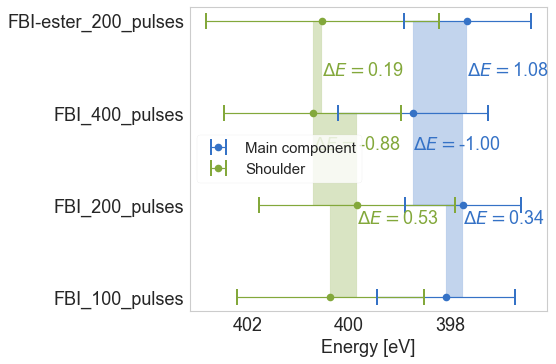

In [109]:
barplot_fit_mtx_fwhm(cu_exps[1:6:2]+[cu_exps[6]], 
                     fitN[:5:2]+[fitN[5]])

In [120]:
barplot_fit_mtx_fwhm(cu_exps[2:5:2]+[cu_exps[7]],
                                     fitN[2:5:2]+[fitN[6]])

In [101]:
def barplot_fit_mtx_fwhm(experiments : list, fit_list : list):
    names = [xp.name for xp in experiments]
    
    fit_mtx = np.zeros((len(fit_list), 4))
    for i,ft in enumerate(fit_list):
        fit_mtx[i] = [ft.params[p].value for p in ['v1_center', 'v1_fwhm', 'v2_center', 'v2_fwhm']]
        
    colv = plt.errorbar(x = fit_mtx[:,0], y = names, xerr=fit_mtx[:,1]/2, fmt='o', mew=2, label='Main component')[0].get_color()

    dif = fit_mtx [:-1,0] - fit_mtx[1:,0]
    for i, d in enumerate(dif) :
        plt.annotate(s = '$\Delta E = $%.2f'%d, xy=(fit_mtx[i+1,0], 0.8 * (i+1)), color=colv)
        plt.fill_betweenx(y=(i, i+1), x1=fit_mtx[i,0], x2=fit_mtx[i+1,0], alpha=0.3, color=colv)

    if fit_mtx.shape[1] > 2:
        colg = plt.errorbar(x = fit_mtx[:,2], y = names, xerr=fit_mtx[:,3]/2, fmt='o', mew=2,label='Shoulder')[0].get_color()
        difg = fit_mtx [:-1,2] - fit_mtx[1:,2]
        for i, d in enumerate(difg) :
            plt.annotate(s = '$\Delta E = $%.2f'%d, xy=(fit_mtx[i+1,2], 0.8 * (i+1)), color=colg)
            plt.fill_betweenx(y=(i, i+1), x1=fit_mtx[i,2], x2=fit_mtx[i+1,2], alpha=0.3, color=colg)
    cosmetics_plot()
    plt.ylabel('')

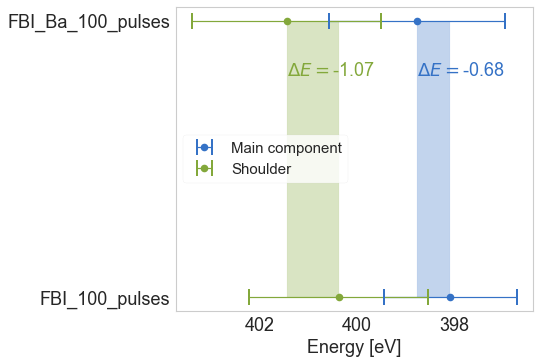

In [23]:
fitN = np.zeros((2, 4))
fitN[0] = [fitFBI.params[p].value for p in ['v1_center', 'v1_fwhm', 'v2_center', 'v2_fwhm']]
fitN[1] = [fitFBIba.params[p].value for p in ['v1_center', 'v1_fwhm', 'v2_center', 'v2_fwhm']]
# fitN
barplot_fit_fwhm(cu_exps[1:3], fitN)

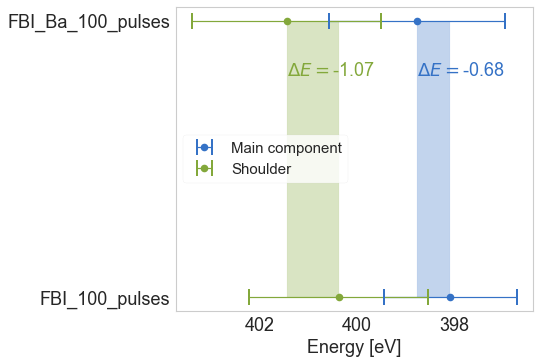

In [23]:
fitN = np.zeros((2, 4))
fitN[0] = [fitFBI.params[p].value for p in ['v1_center', 'v1_fwhm', 'v2_center', 'v2_fwhm']]
fitN[1] = [fitFBIba.params[p].value for p in ['v1_center', 'v1_fwhm', 'v2_center', 'v2_fwhm']]
# fitN
barplot_fit_fwhm(cu_exps[1:3], fitN)

In [15]:
shoulder = comps['v1_']
main = comps['v2_']
area_sho = np.trapz(shoulder, x=x[::-1])
area_main = np.trapz(main, x=x[::-1])

In [19]:
barplot_fit_fwhm([cu_exps[1], cu_exps[2]], fitN)

NameError: name 'expITO' is not defined

###  Compare sputter to DEA/ITO

In [10]:
pathITO = '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/sublim/ITO_DEA*/proc/*.xy'
files = glob.glob(pathITO)
files

['/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/sublim/ITO_DEA_alcohol/proc/20200206_ITO_DEA_alcohol_12min_sublim.xy',
 '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/sublim/ITO_DEA_esther/proc/20200214_ITO_DEA_ester_10min_sublim.xy',
 '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/sublim/ITO_DEA_esther/proc/20200218_ITO_DEA_ester_10min_sublim.xy',
 '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/sublim/ITO_DEA_acid/proc/20200131_ITO_DEA_acid_10min_sublim.xy']

In [11]:
files[2], files[3] = files[3], files[2]

In [15]:
expITO = []
colors=['k', 'purple', 'c', 'm']
for i,f in enumerate(files):
    expITO.append(read_processed_xp(f, color=colors[i]))
    print(expITO[i].name)
for xp in expITO[:-1]:
    xp.dfx.rename(columns={'N1s':'N_1s'}, inplace=True)    

alcohol_sublim
ester_sublim
acid_sublim
ester_sublim_rep


Text(0.5, 1.0, 'N 1s region (normalized), dropcast FBI-Ba and DEA sublimation')

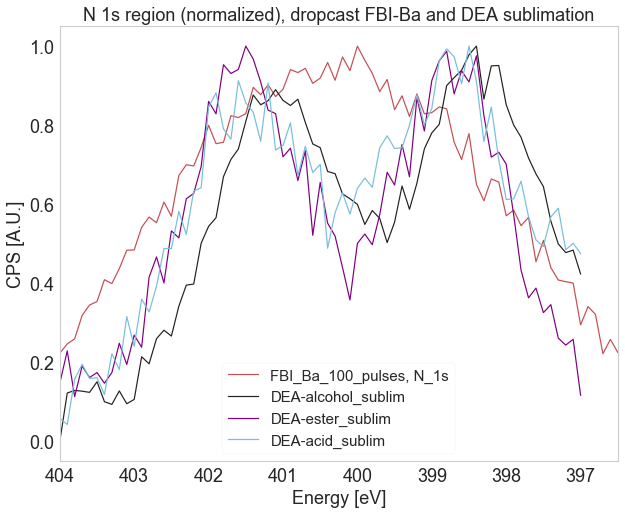

In [129]:
fig, ax = plt.subplots(1, figsize=(10,8))

plot_region(normalise_dfx(cu_exps[2]), region, ax=ax)
for xp in expITO[:-1]:
    xp.dfx.rename(columns={'N1s':'N_1s'}, inplace=True)    
    plot_region(normalise_dfx(xp), region, ax=ax, lb='DEA-'+xp.name)
plt.xlim(404, 396.5)
plt.title('N 1s region (normalized), dropcast FBI-Ba and DEA sublimation')

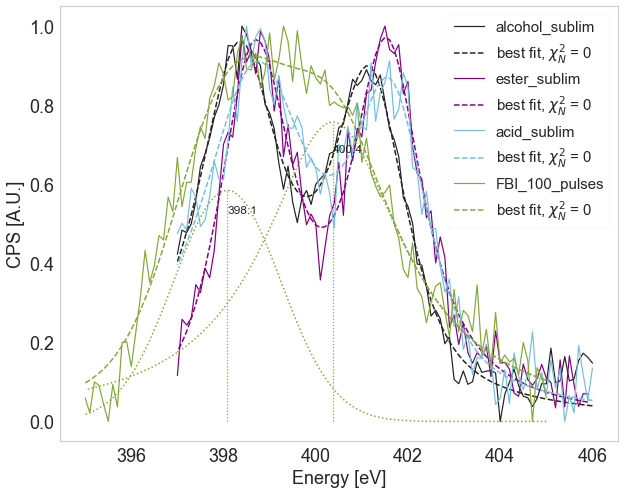

In [130]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
for i, xp in enumerate(expITO[:-1]):
    fitDEA = fit_double_voigt(normalise_dfx(xp), region, sepPt=400, plot_comps=False)
fitDEA = fit_double_voigt(normalise_dfx(cu_exps[1]), region, sepPt=401, plot_comps=True)


In [17]:
region = 'N_1s'
plt.figure(figsize=(10, 8))

fitDEA = fit_double_voigt(normalise_dfx(expITO[1]), region, lb='DEA-'+expITO[1].name, sepPt=400, plot_comps=True)
fitFBI = fit_double_voigt(normalise_dfx(cu_exps[-2]), region, sepPt=401, plot_comps=True)


In [22]:
fitDEA.params

Parameters([('v1_amplitude',
             <Parameter 'v1_amplitude', value=2.08340959312726 +/- 0.201, bounds=[-inf:inf]>),
            ('v1_center',
             <Parameter 'v1_center', value=398.6803243409594 +/- 0.0222, bounds=[-inf:inf]>),
            ('v1_sigma',
             <Parameter 'v1_sigma', value=0.894320498775117 +/- 0.0346, bounds=[0.0:inf]>),
            ('v1_fraction',
             <Parameter 'v1_fraction', value=0.6272572457298717 +/- 0.215, bounds=[0.0:1.0]>),
            ('v1_fwhm',
             <Parameter 'v1_fwhm', value=1.788640997550234 +/- 0.0691, bounds=[-inf:inf], expr='2.0000000*v1_sigma'>),
            ('v1_height',
             <Parameter 'v1_height', value=0.8730094520849623 +/- 0.0265, bounds=[-inf:inf], expr='(((1-v1_fraction)*v1_amplitude)/max(2.220446049250313e-16, (v1_sigma*sqrt(pi/log(2))))+(v1_fraction*v1_amplitude)/max(2.220446049250313e-16, (pi*v1_sigma)))'>),
            ('v2_amplitude',
             <Parameter 'v2_amplitude', value=2.789847736089134 +/- 0.153, bounds=[-inf:inf]>),
            ('v2_center',
             <Parameter 'v2_center', value=401.534497107591 +/- 0.0254, bounds=[-inf:inf]>),
            ('v2_sigma',
             <Parameter 'v2_sigma', value=0.9673655149272282 +/- 0.0452, bounds=[0.0:inf]>),
            ('v2_fraction',
             <Parameter 'v2_fraction', value=0.973697880161617 +/- 0.0835, bounds=[0.0:1.0]>),
            ('v2_fwhm',
             <Parameter 'v2_fwhm', value=1.9347310298544564 +/- 0.0905, bounds=[-inf:inf], expr='2.0000000*v2_sigma'>),
            ('v2_height',
             <Parameter 'v2_height', value=0.9294794063505094 +/- 0.027, bounds=[-inf:inf], expr='(((1-v2_fraction)*v2_amplitude)/max(2.220446049250313e-16, (v2_sigma*sqrt(pi/log(2))))+(v2_fraction*v2_amplitude)/max(2.220446049250313e-16, (pi*v2_sigma)))'>)])

In [23]:
pars = [fitDEA.params['v1_amplitude'].value, fitDEA.params['v1_center'].value, fitDEA.params['v1_sigma'].value, 
        fitDEA.params['v2_amplitude'].value, fitDEA.params['v2_center'].value, fitDEA.params['v2_sigma'].value]

UnboundLocalError: local variable 'pars1' referenced before assignment

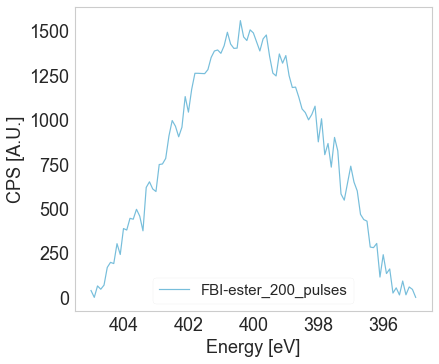

In [25]:
fit_double_voigt(cu_exps[-2], region, sepPt=400, pars=pars, plot_comps=True)

In [82]:
fig, ax = plt.subplots(figsize=(12,8))

fitcu = fit_double_voigt(cu_exps[2], region, sepPt=400, flag_plot=False)

x1 = cu_exps[2].dfx[region].dropna().energy
comps = fitcu.eval_components(x=x1)

ax.plot(x1, fitcu.best_fit, '-r', label='__nolabel__')
for compo in comps:
    colc = ax.plot(x1, comps[compo], ls='dashdot', label='__nolabel__')[0].get_color()

fitITO = []
for xp in expITO[:-1]:
    fitITO.append(fit_double_voigt(xp, region, sepPt=400, flag_plot=False))

    x = xp.dfx[region].dropna().energy
    compsITO = fitITO[-1].eval_components(x=x)
    ax = plt.gca()
    ax.plot(x, fitITO[-1].best_fit, label='__nolabel__')
    for compo in compsITO:
        colc = ax.plot(x, compsITO[compo], ls='dashdot', label='__nolabel__')[0].get_color()
ax.legend()

In [83]:
fitcu

In [100]:
fitN
for i in fitN:
    print(['%.2f'%j for j in i])

['398.42', '1.57', '401.19', '1.43']
['398.34', '2.26', '401.17', '1.90']
['398.68', '1.79', '401.53', '1.93']
['398.72', '3.02', '401.62', '1.88']


In [105]:
fitN
for i in fitN:
    print('%.2f \t%.2f \t%.2f \t%.2f'%(i[0], i[1], i[2], i[3]))

398.42 	1.57 	401.19 	1.43
398.34 	2.26 	401.17 	1.90
398.68 	1.79 	401.53 	1.93
398.72 	3.02 	401.62 	1.88


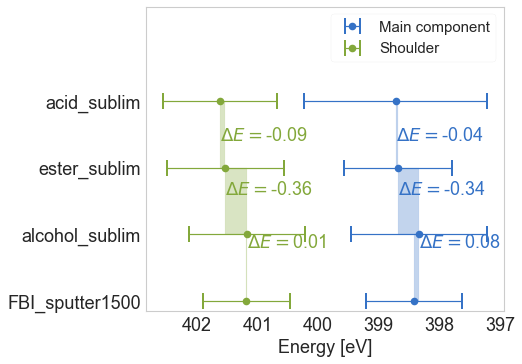

In [88]:
fitN = np.zeros((4, 4))

fitN[0] = [fitcu.params[p].value for p in ['v1_center', 'v1_fwhm', 'v2_center', 'v2_fwhm']]
fitN[1] = [fitITO[0].params[p].value for p in ['v1_center', 'v1_fwhm','v2_center', 'v2_fwhm']]
fitN[2] = [fitITO[1].params[p].value for p in ['v1_center', 'v1_fwhm','v2_center', 'v2_fwhm']]
fitN[3] = [fitITO[2].params[p].value for p in ['v1_center', 'v1_fwhm','v2_center', 'v2_fwhm']]

barplot_fit_fwhm([cu_exps[2], expITO[0], expITO[1], expITO[2]], fitN)

In [92]:
main = comps['v1_']
shoulder = comps['v2_']
area_sho = np.trapz(shoulder, x=x1[::-1])
area_main = np.trapz(main, x=x1[::-1])
area_main/area_sho

2.152334032603748

In [107]:
for fit in fitITO:
    compsITO = fit.eval_components(x=x)
    main = compsITO['v1_']
    shoulder = compsITO['v2_']
    area_sho = np.trapz(shoulder, x=x[::-1])
    area_main = np.trapz(main, x=x[::-1])
    print('%.2f'%(area_main/area_sho))

1.25
0.75
1.85


### Manual fit acid sublim

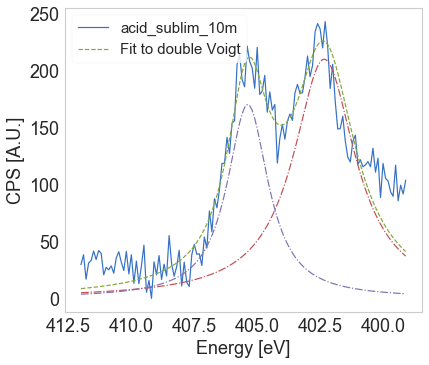

In [162]:
from lmfit.models import PseudoVoigtModel

xp = expITO[1]
sepPt = 404
pars = None
ax = None
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts
if sepPt == None: sepPt = find_separation_point(x, y)

x1 = x[x<sepPt].values
x2 = x[x>sepPt].values
y1 = y[x<sepPt].values
y2 = y[x>sepPt].values
if ax == None : ax = plt.gca()

col = plot_region(xp, region, lb=xp.name, ax=ax).get_color()

mod1 = PseudoVoigtModel(prefix='v1_')
mod2 = PseudoVoigtModel(prefix='v2_')
if pars == None:
    pars1 = mod1.guess(y1, x=x1)
    pars1['v1_sigma'].set(value=1, max=1.5) # Usually guessed wrong anyway
    pars2 = mod2.guess(y2, x=x2)
    pars2['v2_sigma'].set(value=1, max=2.3) # Usually guessed wrong anyway
    pars2['v2_fraction'].set(value=0.8)
    
mod = mod1 + mod2
pars = mod.make_params()
pars.update(pars1)
pars.update(pars2)

fitv = mod.fit(y, pars, x=x)
ax.plot(x, fitv.best_fit, '--', label='Fit to double Voigt')
compsAcid = fitv.eval_components(x=x)
for compo in compsAcid:
        colc = ax.plot(x, compsAcid[compo], ls='dashdot', label='__nolabel__')[0].get_color()
ax.legend()

In [163]:
fitv

In [164]:
compsAcid = fitv.eval_components(x=x)

main = compsAcid['v1_']
shoulder = compsAcid['v2_']
area_sho = np.trapz(shoulder, x=x[::-1])
area_main = np.trapz(main, x=x[::-1])
area_main/area_sho

1.692073897394848

## C 1s 

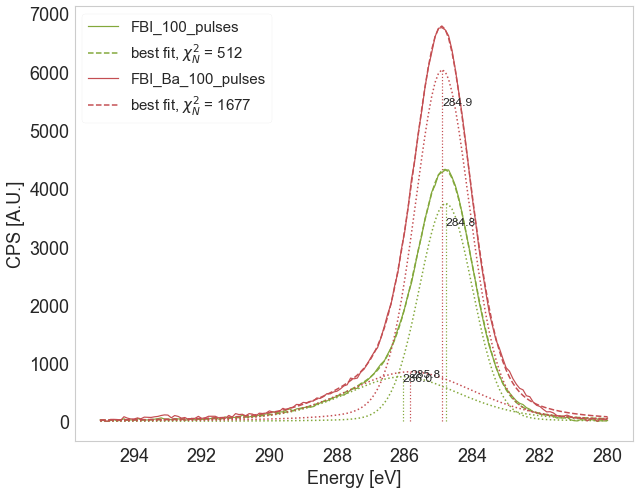

In [37]:
region = 'C_1s'
plt.figure(figsize=(10, 8))
fitcu = fit_double_voigt(cu_exps[1], region, sepPt=286, plot_comps=True)
fitcu = fit_double_voigt(cu_exps[2], region, sepPt=286, plot_comps=True)
cosmetics_plot()

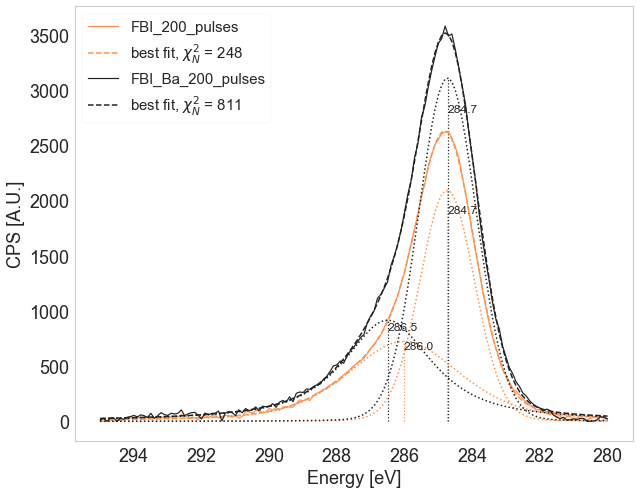

In [38]:
plt.figure(figsize=(10, 8))
fitcu = fit_double_voigt(cu_exps[3], region, sepPt=286, plot_comps=True)
fitcu = fit_double_voigt(cu_exps[4], region, sepPt=286, plot_comps=True)
cosmetics_plot()

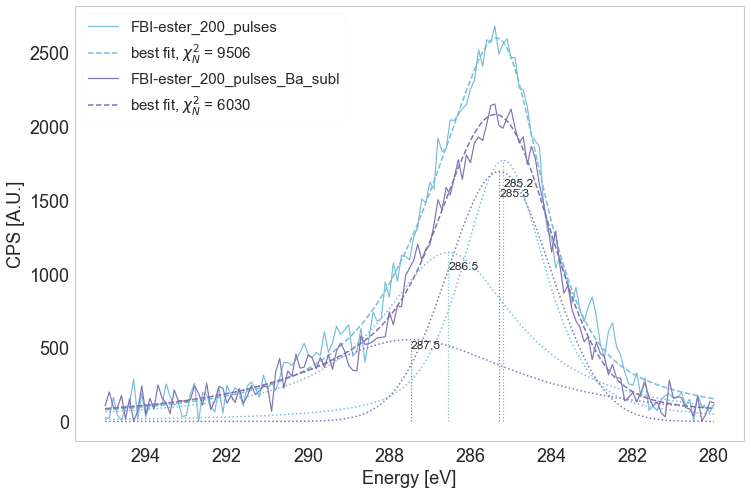

In [40]:
region = 'C_1s'
plt.figure(figsize=(12, 8))
fitcu = fit_double_voigt(cu_exps[6], region, sepPt=286, plot_comps=True)
fitcu = fit_double_voigt(cu_exps[7], region, sepPt=286, plot_comps=True)
cosmetics_plot()

# Seach an oxygen shoulder on a gold peak

## Agent DE COOH data

In [293]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/Au(111)_COOH/*.itx'
files = glob.glob(path)
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/Au(111)_COOH/2020_03_03_Au(111)_2nd_Sublimation_COOH_RT.itx',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/Au(111)_COOH/2020_03_04_Au(111)_anneal_80grad.itx',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/Au(111)_COOH/2020_03_05_Au(111)_anneal_120grad.itx',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/Au(111)_COOH/2020_03_09_Au(111)_anneal_230grad.itx']

In [294]:
names = ['sublimation_rt', 'anneal_80grad', 'anneal_120grad', 'anneal_230grad']
label = ['sublimation_rt', 'anneal_80grad', 'anneal_120grad', 'anneal_230grad']
experiments = [itx_import(f, name=n, label=l) for f,n,l in zip(files, names, label)]

In [295]:
experiments[0].dfx.columns.levels[0]

Index(['1_C1s', '1_Overview', '2_Br3p3/2', '3_Au4f', '4_O1s'], dtype='object', name='range')

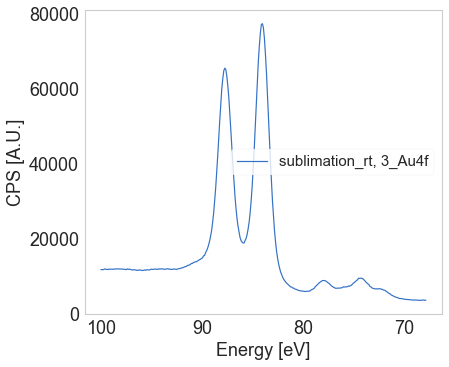

In [296]:
plot_region(experiments[0], '3_Au4f')

(40000.0, 70000.0)

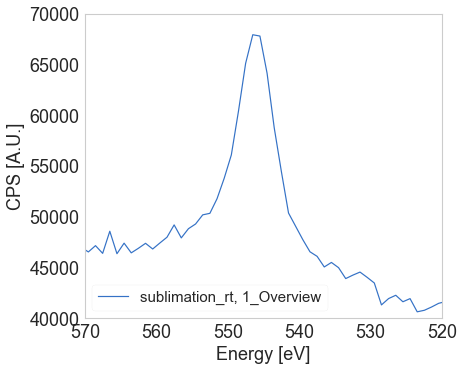

In [297]:
plot_region(experiments[0], '1_Overview')
plt.xlim(570, 520)
# plt.ylim(40e3, 70e3)

In [298]:
plot_region(experiments[0], '4_O1s')

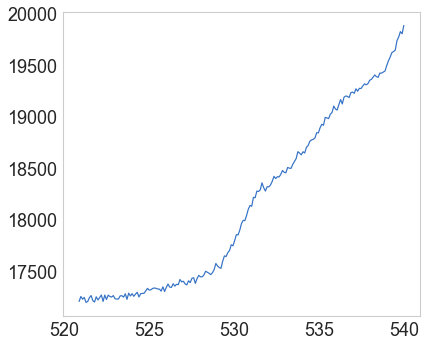

In [300]:
x1,y1 = np.vsplit(experiments[0].dfx['1_Overview'].T.dropna(axis=1).values, 2)
x2, y2 = np.vsplit(experiments[0].dfx['4_O1s'].T.dropna(axis=1).values, 2)
x1,y1, x2, y2 = [j.flatten() for j in (x1,y1,x2,y2)]
plt.plot(x2, y2)

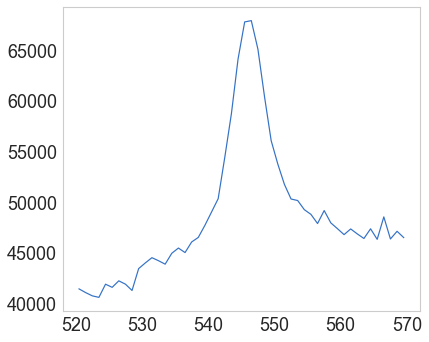

In [301]:
yt = y1[(x1 >= 520) & (x1 <= 570)]
xt = x1[(x1 >= 520) & (x1 <= 570)]
plt.plot(xt, yt)

In [302]:
x2[0], xc[len(xc)-1]
y2[0], yc[len(xc)-1], yc[len(xc)-1] / y2[0]

(19885.1, 86055.0, 4.327612131696597)

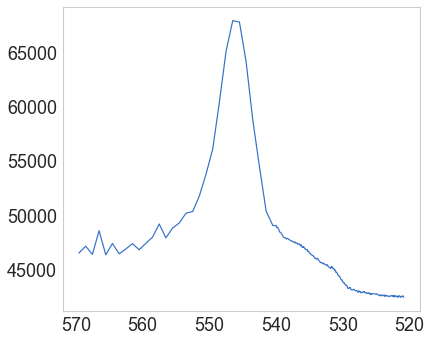

In [303]:
yc = y1[(x1 >= x2[0]) & (x1 <= 570)]
xc = x1[(x1 >= x2[0]) & (x1 <= 570)]
scaling = yc[len(xc) - 1] / y2[0]
x = np.append(xc, x2)
y = np.append(yc, y2 * scaling)
plt.plot(x, y)
plt.gca().invert_xaxis()

(40000.0, 70000.0)

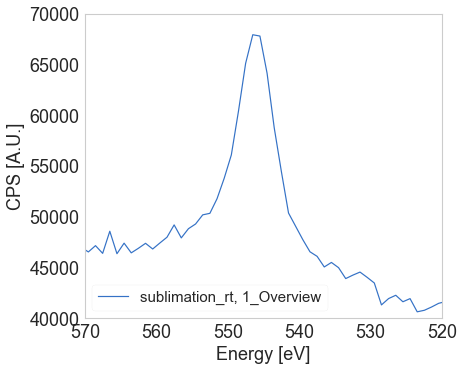

In [308]:
plot_region(experiments[0], '1_Overview')
plt.xlim(570, 520)
plt.ylim(40e3, 70e3)

### Make XPS_experiment and subtract shirley bg

In [309]:
df0 = pd.DataFrame({'energy' : x, 'counts': y})
mi = pd.MultiIndex.from_product([['O_Au'], np.array(['energy', 'counts'])])
mi.to_frame()
df0.columns = mi

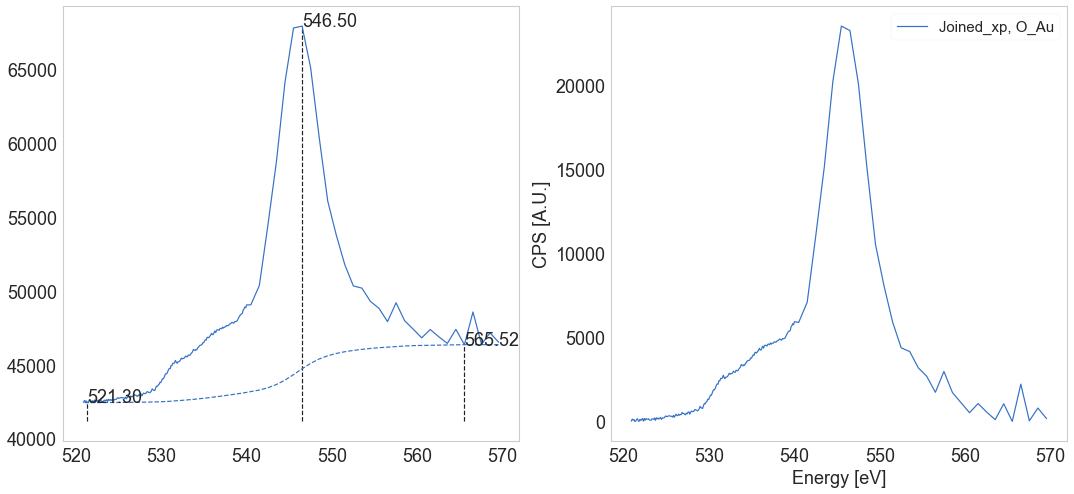

In [310]:
xp = XPS_experiment(name = 'Joined_xp', dfx=df0)
fig, ax = plt.subplots(1,2, figsize=(18, 8))
xp = subtract_shirley_bg(xp, region='O_Au', maxit=100, ax=ax[0])
plot_region(xp, 'O_Au', ax=ax[1])

### Double voigt fit

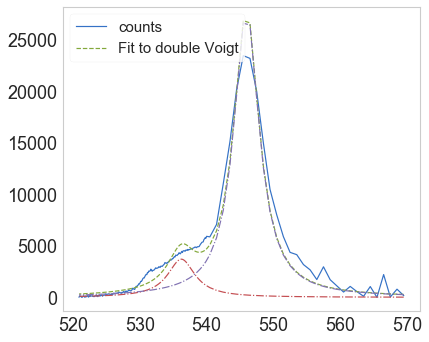

In [312]:
from lmfit.models import PseudoVoigtModel
sepPt = 537
pars = None
ax = None
region = 'O_Au'
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts
if sepPt == None: sepPt = find_separation_point(x, y)

x1 = x[x<sepPt]
x2 = x[x>sepPt]
y1 = y[x<sepPt]
y2 = y[x>sepPt]
if ax == None : ax = plt.gca()

# col = plot_region(xp, region, lb=xp.name, ax=ax).get_color()
col = ax.plot(x, y)[0].get_color()
mod1 = PseudoVoigtModel(prefix='v1_')
mod2 = PseudoVoigtModel(prefix='v2_')

x1.reset_index(drop=True, inplace=True)
y1.reset_index(drop=True, inplace=True)

if pars == None:
    pars1 = mod1.guess(y1, x=x1)
    pars1['v1_sigma'].set(value=1, max=2.5) # Usually guessed wrong anyway
    pars2 = mod2.guess(y2, x=x2)
    pars2['v2_sigma'].set(value=1, max=2.3) # Usually guessed wrong anyway
    pars2['v2_fraction'].set(value=0.8)
    
mod = mod1 + mod2
pars = mod.make_params()
pars.update(pars1)
pars.update(pars2)

fitv = mod.fit(y, pars, x=x)

ax.plot(x, fitv.best_fit, '--', label='Fit to double Voigt')
compsAcid = fitv.eval_components(x=x)
for compo in compsAcid:
    colc = ax.plot(x, compsAcid[compo], ls='dashdot', label='__nolabel__')[0].get_color()
ax.legend()

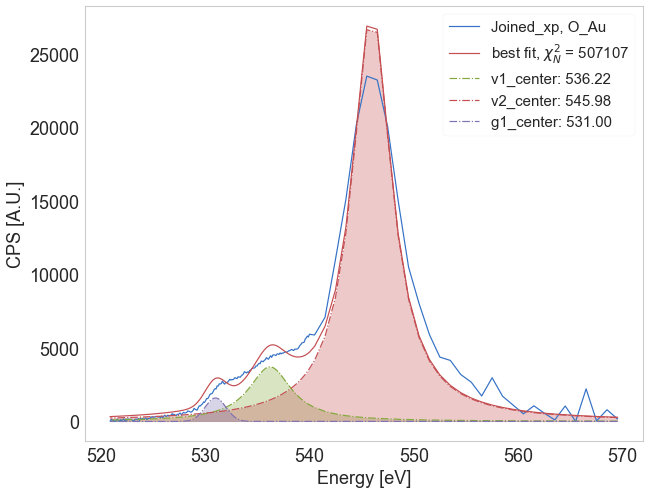

In [315]:
par_g = [4e3, 531, 1]
bounds_g = [(2e3, 6e3), (530, 532), (1.0, 2.5)]
lb = None
flag_plot = True
Ng = 1
ax = None
plt.figure(figsize=(10,8))
from lmfit.models import GaussianModel
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts
if ax == None : ax = plt.gca()
col = plot_region(xp, region, lb, ax).get_color()

gauss2 = GaussianModel(prefix='g'+str(Ng)+'_')
pars = fitv.params
pars.update(gauss2.make_params())

for k,p,b in zip(gauss2.param_names, par_g, bounds_g):
    pars[k].set(value=p, min=b[0], max=b[1])

mod2 = fitv.model + gauss2

fitvg = mod2.fit(y, pars, x=x)
# print(fitvg.fit_report(min_correl=.5))
if flag_plot:
    comps = fitvg.eval_components(x=x)

    ax.plot(x, fitvg.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitvg.redchi)
    for compo in comps:
        colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitvg.best_values[compo+'center']) )[0].get_color()
        ax.fill_between(x, y1 = 0, y2 = comps[compo], alpha=0.3, color=colc)
    ax.legend()
cosmetics_plot(ax=ax)

## Try first with some of my data

In [320]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_30*/*.xy'
files = glob.glob(path)
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_30_Au_crystal_sputter_2kev/20191030_FBI_Ba_Au(788)_sputter_2kev.xy']

In [325]:
names = ['Sputter_2keV_FBI_dropcast', 'anneal_80grad', 'anneal_120grad', 'anneal_230grad']
label = ['3rd cleaning cycle after FBI dropcast', 'anneal_80grad', 'anneal_120grad', 'anneal_230grad']
experiments = [xps_data_import(f, name=n, label=l) for f,n,l in zip(files, names, label)]

In [324]:
experiments[0].dfx.columns.levels[0]

Index(['Ba_3d', 'C_1s', 'Cl_2p', 'Cl_2s', 'N_1s', 'O_1s', 'overview'], dtype='object', name='range')

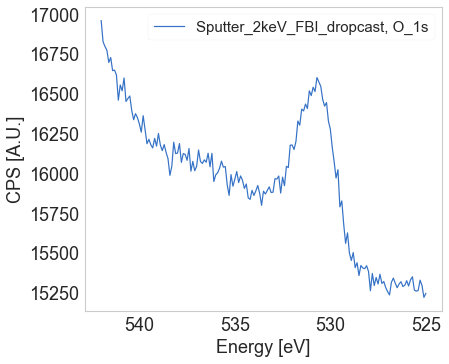

In [266]:
plot_region(experiments[0], 'O_1s')

(78000.0, 100000.0)

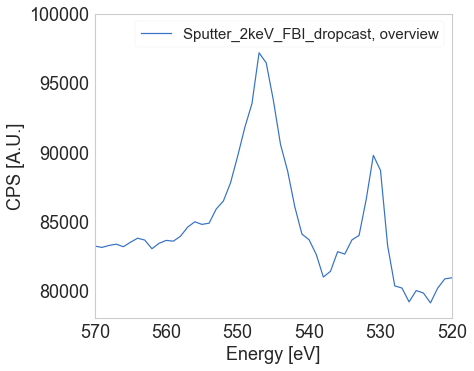

In [267]:
plot_region(experiments[0], 'overview')
plt.xlim(570, 520)
plt.ylim(78e3, 100e3)

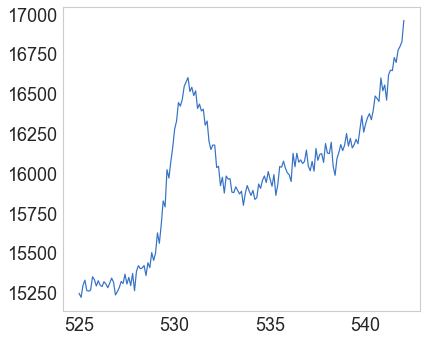

In [326]:
x1,y1 = np.vsplit(experiments[0].dfx['overview'].T.dropna(axis=1).values, 2)
x2, y2 = np.vsplit(experiments[0].dfx['O_1s'].T.dropna(axis=1).values, 2)
x1,y1, x2, y2 = [j.flatten() for j in (x1,y1,x2,y2)]
plt.plot(x2, y2)

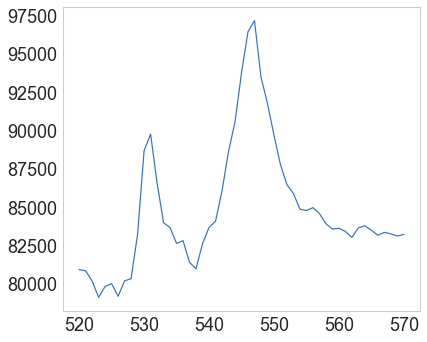

In [327]:
yt = y1[(x1 >= 520) & (x1 <= 570)]
xt = x1[(x1 >= 520) & (x1 <= 570)]
plt.plot(xt, yt)

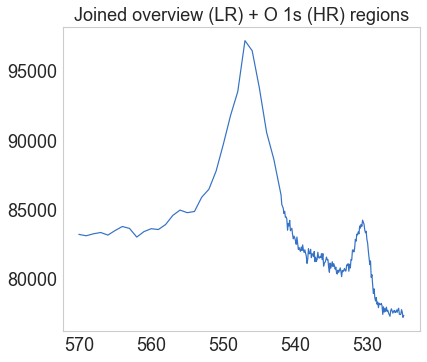

In [329]:
yc = y1[(x1 >= x2[0]) & (x1 <= 570)]
xc = x1[(x1 >= x2[0]) & (x1 <= 570)]
scaling = yc[len(xc) - 1] / y2[0]
x = np.append(xc, x2)
y = np.append(yc, y2 * scaling)
plt.plot(x, y)
plt.title('Joined overview (LR) + O 1s (HR) regions')
plt.gca().invert_xaxis()

(78000.0, 100000.0)

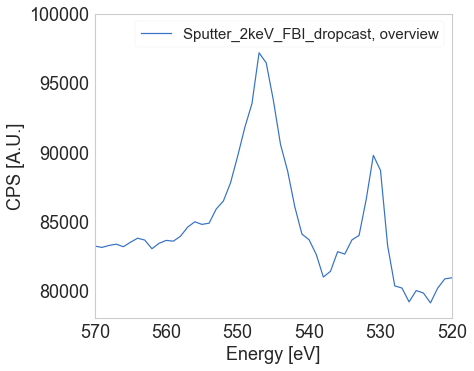

In [270]:
plot_region(experiments[0], 'overview')
plt.xlim(570, 520)
plt.ylim(78e3, 100e3)

### Make XPS_experiment and subtract shirley bg

In [180]:
df0 = pd.DataFrame({'energy' : x, 'counts': y})
mi = pd.MultiIndex.from_product([['O_Au'], np.array(['energy', 'counts'])])
mi.to_frame()
df0.columns = mi

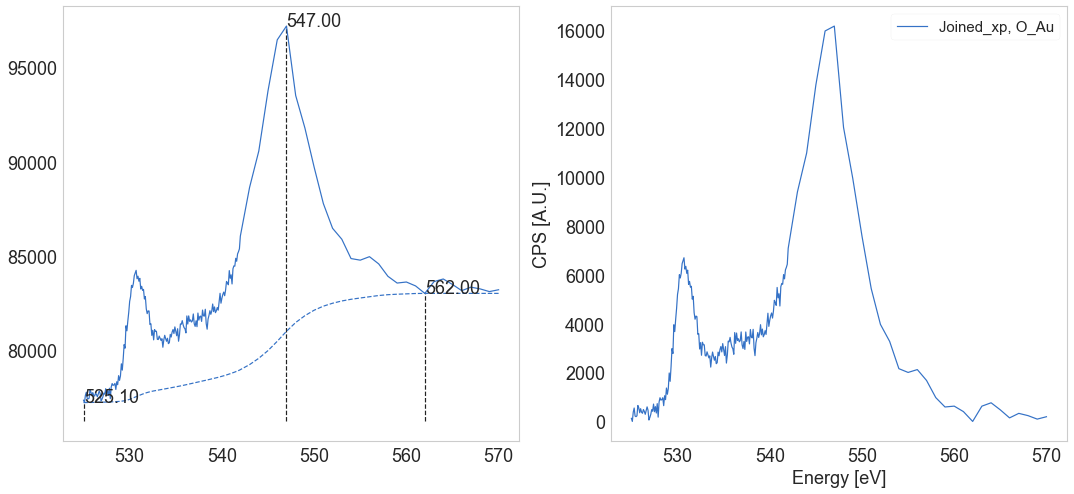

In [184]:
xp = XPS_experiment(name = 'Joined_xp', dfx=df0)
fig, ax = plt.subplots(1,2, figsize=(18, 8))
xp = subtract_shirley_bg(xp, region='O_Au', maxit=100, ax=ax[0])
plot_region(xp, 'O_Au', ax=ax[1])

### Preliminar double voigt fit

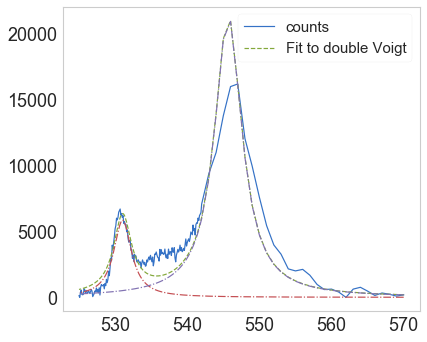

In [244]:
from lmfit.models import PseudoVoigtModel
sepPt = 537
pars = None
ax = None
region = 'O_Au'
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts
if sepPt == None: sepPt = find_separation_point(x, y)

x1 = x[x<sepPt]
x2 = x[x>sepPt]
y1 = y[x<sepPt]
y2 = y[x>sepPt]
if ax == None : ax = plt.gca()

# col = plot_region(xp, region, lb=xp.name, ax=ax).get_color()
col = ax.plot(x, y)[0].get_color()
mod1 = PseudoVoigtModel(prefix='v1_')
mod2 = PseudoVoigtModel(prefix='v2_')

x1.reset_index(drop=True, inplace=True)
y1.reset_index(drop=True, inplace=True)

if pars == None:
    pars1 = mod1.guess(y1, x=x1)
    pars1['v1_sigma'].set(value=1, max=1.5) # Usually guessed wrong anyway
    pars2 = mod2.guess(y2, x=x2)
    pars2['v2_sigma'].set(value=1, max=2.3) # Usually guessed wrong anyway
    pars2['v2_fraction'].set(value=0.8)
    
mod = mod1 + mod2
pars = mod.make_params()
pars.update(pars1)
pars.update(pars2)

fitv = mod.fit(y, pars, x=x)

ax.plot(x, fitv.best_fit, '--', label='Fit to double Voigt')
compsAcid = fitv.eval_components(x=x)
for compo in compsAcid:
    colc = ax.plot(x, compsAcid[compo], ls='dashdot', label='__nolabel__')[0].get_color()
ax.legend()

In [246]:
fitv.params

Parameters([('v1_amplitude',
             <Parameter 'v1_amplitude', 27504.74024073539, bounds=[-inf:inf]>),
            ('v1_center',
             <Parameter 'v1_center', 531.0407091282258, bounds=[-inf:inf]>),
            ('v1_sigma',
             <Parameter 'v1_sigma', 1.4999132536527187, bounds=[0.0:1.5]>),
            ('v1_fraction', <Parameter 'v1_fraction', 1.0, bounds=[0.0:1.0]>),
            ('v1_fwhm',
             <Parameter 'v1_fwhm', 2.9998265073054373, bounds=[-inf:inf], expr='2.0000000*v1_sigma'>),
            ('v1_height',
             <Parameter 'v1_height', 5837.024717410957, bounds=[-inf:inf], expr='(((1-v1_fraction)*v1_amplitude)/max(2.220446049250313e-16, (v1_sigma*sqrt(pi/log(2))))+(v1_fraction*v1_amplitude)/max(2.220446049250313e-16, (pi*v1_sigma)))'>),
            ('v2_amplitude',
             <Parameter 'v2_amplitude', 153864.04283889002, bounds=[-inf:inf]>),
            ('v2_center',
             <Parameter 'v2_center', 545.6876289889823, bounds=[-inf:inf]>),
            ('v2_sigma', <Parameter 'v2_sigma', 2.3, bounds=[0.0:2.3]>),
            ('v2_fraction',
             <Parameter 'v2_fraction', 0.9999999764945045, bounds=[0.0:1.0]>),
            ('v2_fwhm',
             <Parameter 'v2_fwhm', 4.6, bounds=[-inf:inf], expr='2.0000000*v2_sigma'>),
            ('v2_height',
             <Parameter 'v2_height', 21294.10717887719, bounds=[-inf:inf], expr='(((1-v2_fraction)*v2_amplitude)/max(2.220446049250313e-16, (v2_sigma*sqrt(pi/log(2))))+(v2_fraction*v2_amplitude)/max(2.220446049250313e-16, (pi*v2_sigma)))'>)])

### Add a gaussian shoulder at BE = 537 eV

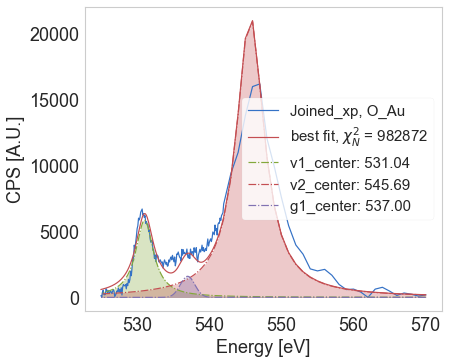

In [263]:
par_g = [4e3, 537, 1]
bounds_g = [(2e3, 6e3), (532, 540), (0.1, 1.5)]
lb = None
flag_plot = True
Ng = 1
ax = None

from lmfit.models import GaussianModel
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts
if ax == None : ax = plt.gca()
col = plot_region(xp, region, lb, ax).get_color()

gauss2 = GaussianModel(prefix='g'+str(Ng)+'_')
pars = fitv.params
pars.update(gauss2.make_params())

for k,p,b in zip(gauss2.param_names, par_g, bounds_g):
    pars[k].set(value=p, min=b[0], max=b[1])

mod2 = fitv.model + gauss2

fitvg = mod2.fit(y, pars, x=x)
# print(fitvg.fit_report(min_correl=.5))
if flag_plot:
    comps = fitvg.eval_components(x=x)

    ax.plot(x, fitvg.best_fit, '-r', label = 'best fit, $\chi^2_N$ = %i' %fitvg.redchi)
    for compo in comps:
        colc = ax.plot(x, comps[compo], ls='dashdot', label = '%scenter: %.2f' %(compo, fitvg.best_values[compo+'center']) )[0].get_color()
        ax.fill_between(x, y1 = 0, y2 = comps[compo], alpha=0.3, color=colc)
    ax.legend()
cosmetics_plot(ax=ax)

## Try to fit from starting 'O_1s' region

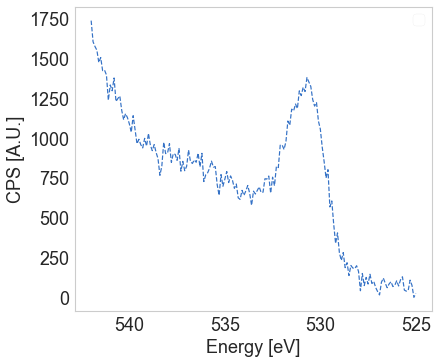

In [284]:
xp = experiments[0]
region = 'O_1s'
maxit = 40
ax = None
x, y = xp.dfx[region].dropna().energy.values, xp.dfx[region].dropna().counts.values

ybg = y.min()
y - ybg

if ax == None: ax = plt.gca()
ax.plot(x, y-ybg, '--', color='b', label=lb);
cosmetics_plot(ax = ax)

dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
xpNew = deepcopy(xp)
xpNew.dfx[region] = dfnew

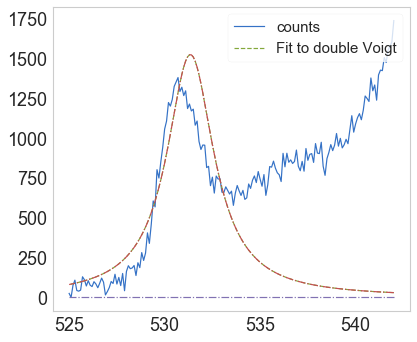

In [292]:
from lmfit.models import PseudoVoigtModel
sepPt = 537
pars = None
ax = None
xp = xpNew
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts
if sepPt == None: sepPt = find_separation_point(x, y)

x1 = x[x<sepPt]
x2 = x[x>sepPt]
y1 = y[x<sepPt]
y2 = y[x>sepPt]
if ax == None : ax = plt.gca()

# col = plot_region(xp, region, lb=xp.name, ax=ax).get_color()
col = ax.plot(x, y)[0].get_color()
mod1 = PseudoVoigtModel(prefix='v1_')
mod2 = PseudoVoigtModel(prefix='v2_')

x1.reset_index(drop=True, inplace=True)
y1.reset_index(drop=True, inplace=True)

if pars == None:
    pars1 = mod1.guess(y1, x=x1)
    pars1['v1_sigma'].set(value=1, max=1.5) # Usually guessed wrong anyway
    pars2 = mod2.guess(y2, x=x2)
    pars2['v2_sigma'].set(value=1, max=2.3) # Usually guessed wrong anyway
    pars2['v2_fraction'].set(value=0.8)
pars2['v2_center'].set(value=545.7, min=544)

mod = mod1 + mod2
pars = mod.make_params()
pars.update(pars1)
pars.update(pars2)

fitv = mod.fit(y, pars, x=x)

ax.plot(x, fitv.best_fit, '--', label='Fit to double Voigt')
compsAcid = fitv.eval_components(x=x)
for compo in compsAcid:
    colc = ax.plot(x, compsAcid[compo], ls='dashdot', label='__nolabel__')[0].get_color()
ax.legend()

##### Not working...